In [1]:
file_path = r"C:\Users\Shirley\Downloads\OpenStack_2k.log"

with open(file_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

lines[:20]   # 看前 20 行


['nova-api.log.1.2017-05-16_13:53:08 2017-05-16 00:00:00.008 25746 INFO nova.osapi_compute.wsgi.server [req-38101a0b-2096-447d-96ea-a692162415ae 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" status: 200 len: 1893 time: 0.2477829\n',
 'nova-api.log.1.2017-05-16_13:53:08 2017-05-16 00:00:00.272 25746 INFO nova.osapi_compute.wsgi.server [req-9bc36dd9-91c5-4314-898a-47625eb93b09 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" status: 200 len: 1893 time: 0.2577181\n',
 'nova-api.log.1.2017-05-16_13:53:08 2017-05-16 00:00:01.551 25746 INFO nova.osapi_compute.wsgi.server [req-55db2d8d-cdb7-4b4b-993b-429be84c0c3e 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" status: 200 len: 1893 time: 

In [2]:
# Step 1: Parse OpenStack_2k.log into a structured DataFrame
import re
import pandas as pd
from datetime import datetime
from pathlib import Path

# ---------- 配置（不需要改） ----------
file_path = r"C:\Users\Shirley\Downloads\OpenStack_2k.log"
output_csv = r"C:\Users\Shirley\Downloads\openstack_parsed.csv"
# ---------------------------------------

# 参考日志样例构造的正则（尽量覆盖常见字段）
log_re = re.compile(
    r'^(?P<file>\S+)\s+'                                      # filename at line start
    r'(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d+)\s+'  # timestamp
    r'(?P<pid>\d+)\s+'                                       # pid
    r'(?P<level>[A-Z]+)\s+'                                  # level INFO/ERROR/...
    r'(?P<module>[^\s]+)\s+'                                 # module
    r'(?P<rest>.*)$'                                         # the rest (message)
)

# helper regexes to further extract from "rest"
ip_re       = re.compile(r'(?P<ip>\d{1,3}(?:\.\d{1,3}){3})')
status_re   = re.compile(r'status:\s*(?P<status>\d{3})')
time_re     = re.compile(r'time:\s*(?P<latency>\d+\.\d+)')   # float time
reqid_re    = re.compile(r'\[?(req-[0-9a-fA-F\-]+)\]?')     # request id like req-xxxx

rows = []
with open(file_path, "r", encoding="utf-8", errors="replace") as f:
    for i, line in enumerate(f):
        line = line.rstrip("\n")
        m = log_re.match(line)
        if not m:
            # 解析失败：保留原始行，标记 parse_ok=False
            rows.append({
                "file": None,
                "timestamp": None,
                "pid": None,
                "level": None,
                "module": None,
                "message": line,
                "ip": None,
                "status": None,
                "latency": None,
                "request_id": None,
                "parse_ok": False
            })
            continue

        gd = m.groupdict()
        rest = gd.pop("rest").strip()

        # extract further fields from rest
        ip = ip_re.search(rest)
        ip = ip.group("ip") if ip else None

        status = status_re.search(rest)
        status = int(status.group("status")) if status else None

        latency = time_re.search(rest)
        latency = float(latency.group("latency")) if latency else None

        reqid = reqid_re.search(rest)
        reqid = reqid.group(1) if reqid else None

        # try parse timestamp -> datetime
        ts = None
        try:
            ts = datetime.strptime(gd["timestamp"], "%Y-%m-%d %H:%M:%S.%f")
        except Exception:
            ts = None

        rows.append({
            "file": gd.get("file"),
            "timestamp": ts,
            "pid": int(gd["pid"]) if gd.get("pid") and gd["pid"].isdigit() else None,
            "level": gd.get("level"),
            "module": gd.get("module"),
            "message": rest,
            "ip": ip,
            "status": status,
            "latency": latency,
            "request_id": reqid,
            "parse_ok": True
        })

# build dataframe
df = pd.DataFrame(rows)

# basic sanity: show total lines and parse rate
total = len(df)
parsed = df['parse_ok'].sum()
print(f"Total lines: {total:,}, parsed successfully: {parsed:,} ({parsed/total:.1%})")

# show first rows
display(df.head(10))

# save to csv for later steps
df.to_csv(output_csv, index=False)
print(f"Saved parsed DataFrame to: {output_csv}")


Total lines: 2,000, parsed successfully: 2,000 (100.0%)


,file,timestamp,pid,level,module,message,ip,status,latency,request_id,parse_ok
0,nova-api.log.1.2017-05-16_13:53:08,2017-05-16 00:00:00.008,25746,INFO,nova.osapi_compute.wsgi.server,[req-38101a0b-2096-447d-96ea-a692162415ae 113d...,10.11.10.1,200.0,0.247783,req-38101a0b-2096-447d-96ea-a692162415ae,True
1,nova-api.log.1.2017-05-16_13:53:08,2017-05-16 00:00:00.272,25746,INFO,nova.osapi_compute.wsgi.server,[req-9bc36dd9-91c5-4314-898a-47625eb93b09 113d...,10.11.10.1,200.0,0.257718,req-9bc36dd9-91c5-4314-898a-47625eb93b09,True
2,nova-api.log.1.2017-05-16_13:53:08,2017-05-16 00:00:01.551,25746,INFO,nova.osapi_compute.wsgi.server,[req-55db2d8d-cdb7-4b4b-993b-429be84c0c3e 113d...,10.11.10.1,200.0,0.273163,req-55db2d8d-cdb7-4b4b-993b-429be84c0c3e,True
3,nova-api.log.1.2017-05-16_13:53:08,2017-05-16 00:00:01.813,25746,INFO,nova.osapi_compute.wsgi.server,[req-2a3dc421-6604-42a7-9390-a18dc824d5d6 113d...,10.11.10.1,200.0,0.258025,req-2a3dc421-6604-42a7-9390-a18dc824d5d6,True
4,nova-api.log.1.2017-05-16_13:53:08,2017-05-16 00:00:03.091,25746,INFO,nova.osapi_compute.wsgi.server,[req-939eb332-c1c1-4e67-99b8-8695f8f1980a 113d...,10.11.10.1,200.0,0.272793,req-939eb332-c1c1-4e67-99b8-8695f8f1980a,True
5,nova-api.log.1.2017-05-16_13:53:08,2017-05-16 00:00:03.358,25746,INFO,nova.osapi_compute.wsgi.server,[req-b6a4fa91-7414-432a-b725-52b5613d3ca3 113d...,10.11.10.1,200.0,0.264213,req-b6a4fa91-7414-432a-b725-52b5613d3ca3,True
6,nova-compute.log.1.2017-05-16_13:55:31,2017-05-16 00:00:04.500,2931,INFO,nova.compute.manager,[req-3ea4052c-895d-4b64-9e2d-04d64c4d94ab - - ...,None,NaN,NaN,req-3ea4052c-895d-4b64-9e2d-04d64c4d94ab,True
7,nova-compute.log.1.2017-05-16_13:55:31,2017-05-16 00:00:04.562,2931,INFO,nova.compute.manager,[req-3ea4052c-895d-4b64-9e2d-04d64c4d94ab - - ...,None,NaN,NaN,req-3ea4052c-895d-4b64-9e2d-04d64c4d94ab,True
8,nova-compute.log.1.2017-05-16_13:55:31,2017-05-16 00:00:04.693,2931,INFO,nova.compute.manager,[req-3ea4052c-895d-4b64-9e2d-04d64c4d94ab - - ...,None,NaN,NaN,req-3ea4052c-895d-4b64-9e2d-04d64c4d94ab,True
9,nova-api.log.1.2017-05-16_13:53:08,2017-05-16 00:00:04.789,25746,INFO,nova.osapi_compute.wsgi.server,[req-bbfc3fb8-7cb3-4ac8-801e-c893d1082762 113d...,10.11.10.1,200.0,0.425697,req-bbfc3fb8-7cb3-4ac8-801e-c893d1082762,True


Saved parsed DataFrame to: C:\Users\Shirley\Downloads\openstack_parsed.csv


In [3]:
import pandas as pd

# === Step 2: 读取第一步的解析结果 ===
parsed_path = r"C:\Users\Shirley\Downloads\openstack_parsed.csv"
df = pd.read_csv(parsed_path, parse_dates=['timestamp'])

print("Parsed file loaded:", df.shape)

# === Step 2.1 时间归一化：按分钟聚合 ===
df['minute'] = df['timestamp'].dt.floor('T')   # 按分钟取整

# === Step 2.2 计算时间序列指标 ===

# 1. 每分钟日志数量
ts_event_count = df.groupby('minute').size().rename("event_count")

# 2. 每分钟 ERROR 数量
ts_error_count = df[df['level'] == "ERROR"].groupby('minute').size().rename("error_count")

# 3. 每分钟平均 latency（已有真实 KPI）
ts_avg_latency = df.groupby('minute')['latency'].mean().rename("avg_latency")

# 合并三个指标
metrics = pd.concat([ts_event_count, ts_error_count, ts_avg_latency], axis=1)

# 如果某分钟没有 error，则补 0
metrics['error_count'] = metrics['error_count'].fillna(0)

print("Generated metrics:")
print(metrics.head())

# === Step 2.3 保存输出 ===
output_path = r"C:\Users\Shirley\Downloads\openstack_metrics.csv"
metrics.to_csv(output_path)

print("\nSaved time-series metrics to:", output_path)


Parsed file loaded: (2000, 11)
Generated metrics:
                     event_count  error_count  avg_latency
minute                                                    
2017-05-16 00:00:00          141          0.0     0.228631
2017-05-16 00:01:00          124          0.0     0.240790
2017-05-16 00:02:00          129          0.0     0.261009
2017-05-16 00:03:00          135          0.0     0.232622
2017-05-16 00:04:00          130          0.0     0.263907

Saved time-series metrics to: C:\Users\Shirley\Downloads\openstack_metrics.csv


C:\Users\Shirley\AppData\Local\Temp\ipykernel_20632\2025905637.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['timestamp'].dt.floor('T')   # 按分钟取整


In [4]:
import pandas as pd
import re

# === Step 3: 读取之前的解析结果 ===
parsed_path = r"C:\Users\Shirley\Downloads\openstack_parsed.csv"
df = pd.read_csv(parsed_path)

print("Loaded parsed logs:", df.shape)

# === Step 3.1 清洗 log message 文本 ===

def clean_log_text(text):
    if pd.isna(text):
        return ""

    # 去掉 request id 格式 [req-xxxx]
    text = re.sub(r'\[req-[^\]]+\]', '', text)

    # 去掉 UUID
    text = re.sub(r'\b[0-9a-fA-F-]{36}\b', '<UUID>', text)

    # 去掉 IP 地址
    text = re.sub(r'\b\d+\.\d+\.\d+\.\d+\b', '<IP>', text)

    # 去掉多余数字（参数数字对 NLP 意义不大）
    text = re.sub(r'\b\d+\b', '<NUM>', text)

    # 多余空格
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df["clean_message"] = df["message"].apply(clean_log_text)

# === Step 3.2 简单模板提取（将数字/IP/UUID 用 <*> 占位） ===

def extract_template(text):
    t = text
    t = re.sub(r'<IP>', '<*>', t)
    t = re.sub(r'<UUID>', '<*>', t)
    t = re.sub(r'<NUM>', '<*>', t)
    return t

df["template"] = df["clean_message"].apply(extract_template)

# === Step 3.3 保存输出文件 ===

clean_path = r"C:\Users\Shirley\Downloads\openstack_logs_clean.csv"
template_path = r"C:\Users\Shirley\Downloads\openstack_log_templates.csv"

df[["timestamp", "level", "module", "clean_message"]].to_csv(clean_path, index=False)
df[["timestamp", "level", "module", "template"]].to_csv(template_path, index=False)

print("\nSaved cleaned logs:", clean_path)
print("Saved template logs:", template_path)

# 预览模板结果
print("\nExample templates:")
print(df["template"].head(10))


Loaded parsed logs: (2000, 11)

Saved cleaned logs: C:\Users\Shirley\Downloads\openstack_logs_clean.csv
Saved template logs: C:\Users\Shirley\Downloads\openstack_log_templates.csv

Example templates:
0    <*> "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/...
1    <*> "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/...
2    <*> "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/...
3    <*> "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/...
4    <*> "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/...
5    <*> "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/...
6         [instance: <*>] VM Started (Lifecycle Event)
7          [instance: <*>] VM Paused (Lifecycle Event)
8    [instance: <*>] During sync_power_state the in...
9    <*> "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/...
Name: template, dtype: object


In [12]:
import pandas as pd
import numpy as np
import os

base = r"C:\Users\Shirley\Downloads"
metrics_file = os.path.join(base, "openstack_metrics.csv")
metrics = pd.read_csv(metrics_file)

np.random.seed(42)

# 强制注入 6 个异常（如果数据少，就取全部行）
anom_count = min(6, len(metrics))
anom_indices = np.random.choice(metrics.index, size=anom_count, replace=False)

metrics['is_anom'] = 0

for i in anom_indices:
    metrics.loc[i, 'avg_latency'] *= np.random.uniform(3, 7)
    metrics.loc[i, 'event_count'] = float(metrics.loc[i, 'event_count']) * np.random.uniform(2, 5)
    metrics.loc[i, 'error_count'] = np.random.randint(1, 5)
    metrics.loc[i, 'is_anom'] = 1

out = os.path.join(base, "openstack_metrics_with_anomaly.csv")
metrics.to_csv(out, index=False)

print("Forced anomalies injected:", anom_count)
print("Saved:", out)


Forced anomalies injected: 6
Saved: C:\Users\Shirley\Downloads\openstack_metrics_with_anomaly.csv


C:\Users\Shirley\AppData\Local\Temp\ipykernel_20632\2192385182.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '644.2844632719891' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  metrics.loc[i, 'event_count'] = float(metrics.loc[i, 'event_count']) * np.random.uniform(2, 5)


In [15]:
# A. Data preparation: load metrics, create labels, train/test split, build template sequences
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

# paths
metrics_path = r"C:\Users\Shirley\Downloads\openstack_metrics_with_anomaly.csv"
metrics = pd.read_csv(metrics_path, parse_dates=['minute']).set_index('minute').sort_index()
templates_path = r"C:\Users\Shirley\Downloads\openstack_log_templates.csv"
clean_logs_path = r"C:\Users\Shirley\Downloads\openstack_logs_clean.csv"

# load
metrics = pd.read_csv(metrics_path, parse_dates=['minute']).set_index('minute').sort_index()
templates = pd.read_csv(templates_path, parse_dates=['timestamp']).sort_values('timestamp')
clean_logs = pd.read_csv(clean_logs_path, parse_dates=['timestamp']).sort_values('timestamp')

# 1) create weak binary label at minute level: is_anom = error_count > 0
metrics['is_anom'] = (metrics['error_count'] > 0).astype(int)

# 2) train/test split by time: first 70% minutes = train, last 30% = test
minutes = metrics.index.unique().sort_values()
n = len(minutes)
split_idx = int(0.7 * n)
train_minutes = minutes[:split_idx]
test_minutes = minutes[split_idx:]

metrics_train = metrics.loc[train_minutes].copy()
metrics_test = metrics.loc[test_minutes].copy()

print("Minutes total:", n, "train:", len(metrics_train), "test:", len(metrics_test))
print("Train anomaly rate:", metrics_train['is_anom'].mean(), "Test anomaly rate:", metrics_test['is_anom'].mean())

# 3) prepare features for classical model (numeric)
num_features = ['event_count', 'avg_latency', 'error_count']  # error_count included (IsolationForest unsupervised will still use it but label is weak)
X_train = metrics_train[num_features].fillna(0).values
X_test = metrics_test[num_features].fillna(0).values
y_test = metrics_test['is_anom'].values

# 4) prepare sequence data for LSTM self-supervised model
# We will map templates to integer ids and create sliding sequences by event order.
templates['template'] = templates['template'].astype(str).fillna('')  # ensure str
# create template -> id mapping (fit on full dataset to have consistent mapping)
unique_templates = templates['template'].unique().tolist()
tpl2id = {t:i+1 for i,t in enumerate(unique_templates)}  # reserve 0 for padding
id2tpl = {i+1:t for i,t in enumerate(unique_templates)}
print("Unique templates:", len(unique_templates))

# map each log line to template id
templates['tpl_id'] = templates['template'].map(tpl2id)

# Create sequences of tpl_ids in chronological order
tpl_ids = templates['tpl_id'].values.tolist()
timestamps = templates['timestamp'].values

# We'll create sliding windows of length seq_len -> target next token
seq_len = 10  # you can adjust
X_seqs = []
y_seqs = []
seq_minutes = []  # map each sequence to minute (for aggregating anomaly scores)
for i in range(len(tpl_ids) - seq_len):
    seq = tpl_ids[i:i+seq_len]
    target = tpl_ids[i+seq_len]
    ts_for_seq = templates['timestamp'].iloc[i+seq_len]  # time of the target event
    minute = pd.to_datetime(ts_for_seq).floor('min')
    X_seqs.append(seq)
    y_seqs.append(target)
    seq_minutes.append(minute)

X_seqs = np.array(X_seqs, dtype=np.int64)
y_seqs = np.array(y_seqs, dtype=np.int64)
seq_minutes = np.array(seq_minutes, dtype='datetime64[ns]')

# split sequences into train/test using minute-based mask (same split boundary as metrics)
train_mask = seq_minutes < test_minutes[0]
test_mask = ~train_mask

X_seqs_train = X_seqs[train_mask]
y_seqs_train = y_seqs[train_mask]
X_seqs_test = X_seqs[test_mask]
y_seqs_test = y_seqs[test_mask]
seq_minutes_test = seq_minutes[test_mask]

print("Seqs total:", len(X_seqs), "train seqs:", len(X_seqs_train), "test seqs:", len(X_seqs_test))


Minutes total: 15 train: 10 test: 5
Train anomaly rate: 0.4 Test anomaly rate: 0.4
Unique templates: 121
Seqs total: 1990 train seqs: 1343 test seqs: 647


IsolationForest results (contamination 0.05): prec=1.000, rec=0.500, f1=0.667


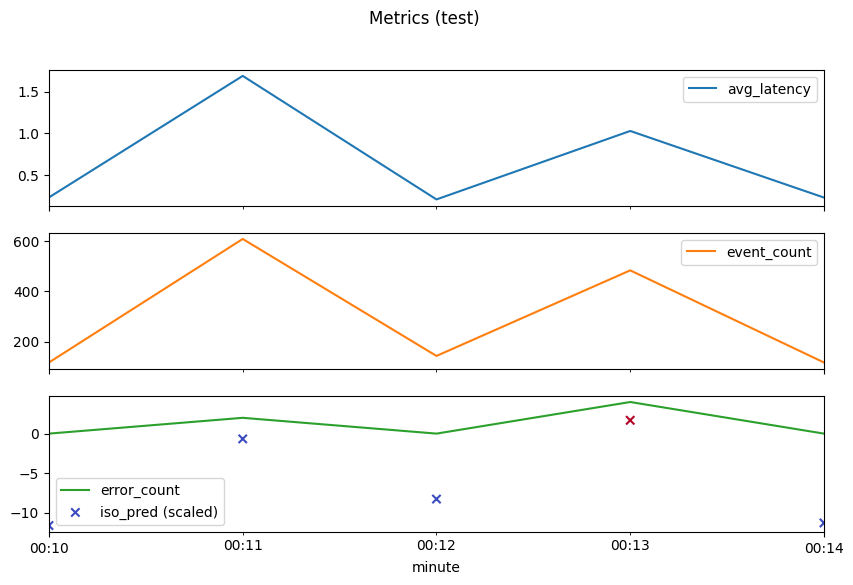

In [16]:
# B. Classical model: IsolationForest on per-minute numeric features
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# train unsupervised IsolationForest on X_train
clf = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)  
# contamination can be estimated; 0.05 means assume 5% anomalies — you can change
clf.fit(X_train)

# anomaly score (negative = more abnormal for sklearn's decision_function; use -score to have higher = more anomalous)
scores_test = -clf.decision_function(X_test)  # higher -> more anomalous

# choose threshold: we can use top K percentile (here use contamination) or optimize by maximizing F1 against weak label
contamination = 0.05
th = np.percentile(scores_test, 100*(1-contamination))  # top 5% as anomaly
y_pred = (scores_test >= th).astype(int)

# Evaluate against weak label (error_count > 0)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("IsolationForest results (contamination {:.2f}): prec={:.3f}, rec={:.3f}, f1={:.3f}".format(contamination, prec, rec, f1))

# Also show a simple plot of metrics with predicted anomalies
metrics_test_plot = metrics_test.copy()
metrics_test_plot['iso_score'] = scores_test
metrics_test_plot['iso_pred'] = y_pred
metrics_test_plot[['avg_latency','event_count','error_count']].plot(subplots=True, figsize=(10,6), title="Metrics (test)")
plt.scatter(metrics_test_plot.index, metrics_test_plot['iso_score']/metrics_test_plot['iso_score'].max() * metrics_test_plot['avg_latency'].max(),
            c=metrics_test_plot['iso_pred'], cmap='coolwarm', marker='x', label='iso_pred (scaled)')
plt.legend()
plt.show()


Using device: cpu
Epoch 1/8, loss=3.9488, time=0.4s
Epoch 2/8, loss=3.0626, time=0.3s
Epoch 3/8, loss=2.6609, time=0.3s
Epoch 4/8, loss=2.2564, time=0.3s
Epoch 5/8, loss=1.9145, time=0.3s
Epoch 6/8, loss=1.6376, time=0.3s
Epoch 7/8, loss=1.4170, time=0.3s
Epoch 8/8, loss=1.2668, time=0.3s
LSTM next-event results (any-type, contamination 0.05): prec=0.155, rec=1.000, f1=0.268

Per-type LSTM results:
              precision  recall        f1  count
anom_perf     0.040000     1.0  0.076923   24.0
anom_fail     0.068333     1.0  0.127925   41.0
anom_config   0.016667     1.0  0.032787   10.0
anom_sec      0.035000     1.0  0.067633   21.0


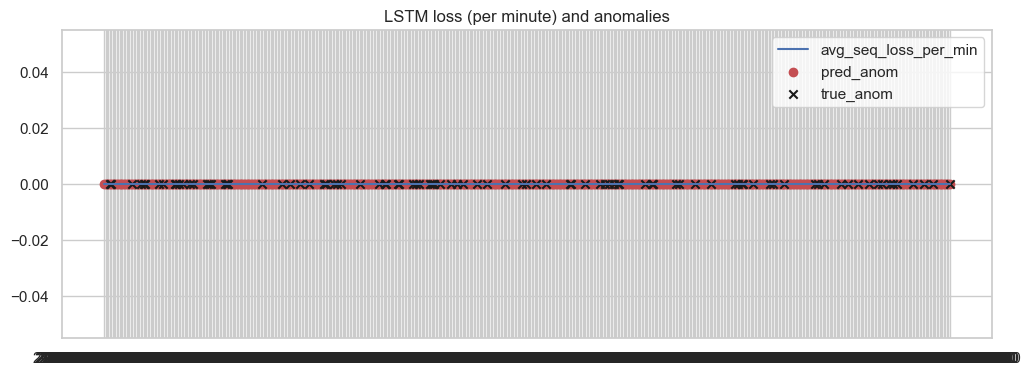

In [38]:
# === C. Self-supervised LSTM next-event prediction (PyTorch) ===
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Dataset class ---
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# --- Parameters ---
vocab_size = len(unique_templates) + 1  # +1 for padding 0
embed_dim = 64
hidden = 128
batch_size = 64
epochs = 8

train_dataset = SeqDataset(X_seqs_train, y_seqs_train)
test_dataset = SeqDataset(X_seqs_test, y_seqs_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- LSTM Model ---
class LSTMNext(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, vocab_size)
    def forward(self, x):
        e = self.emb(x)
        out, _ = self.lstm(e)
        h = out[:, -1, :]
        logits = self.fc(h)
        return logits

model = LSTMNext(vocab_size=vocab_size, emb_dim=embed_dim, hidden=hidden).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Training loop ---
model.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    t0 = time.time()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, loss={epoch_loss:.4f}, time={time.time()-t0:.1f}s")

# --- Evaluation ---
model.eval()
seq_losses = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = nn.functional.cross_entropy(logits, yb, reduction='none')
        seq_losses.extend(loss.cpu().numpy().tolist())

seq_losses = np.array(seq_losses)

# Align per-sequence loss to test minutes
df_seq_loss = pd.DataFrame({'minute': pd.to_datetime(seq_minutes_test), 'loss': seq_losses})
loss_by_min = df_seq_loss.groupby('minute')['loss'].mean().reindex(metrics_test.index).fillna(0)

# --- Generate any-type anomaly label ---
metrics_test['is_anom'] = metrics_test[['anom_perf','anom_fail','anom_config','anom_sec']].max(axis=1)
y_true = metrics_test['is_anom'].values

# --- Map loss -> anomaly via percentile threshold ---
contamination = 0.05
th_loss = np.percentile(loss_by_min.values, 100*(1-contamination))
y_pred_lstm = (loss_by_min.values >= th_loss).astype(int)

# --- Metrics for RQ1 ---
prec_l = precision_score(y_true, y_pred_lstm, zero_division=0)
rec_l = recall_score(y_true, y_pred_lstm, zero_division=0)
f1_l = f1_score(y_true, y_pred_lstm, zero_division=0)
print("LSTM next-event results (any-type, contamination {:.2f}): prec={:.3f}, rec={:.3f}, f1={:.3f}".format(
    contamination, prec_l, rec_l, f1_l))

# --- Metrics for RQ2 (per-type) ---
types = ['anom_perf','anom_fail','anom_config','anom_sec']
results = {}
for t in types:
    y_true_type = metrics_test[t].values
    results[t] = {
        'precision': precision_score(y_true_type, y_pred_lstm, zero_division=0),
        'recall': recall_score(y_true_type, y_pred_lstm, zero_division=0),
        'f1': f1_score(y_true_type, y_pred_lstm, zero_division=0),
        'count': y_true_type.sum()
    }
df_results = pd.DataFrame(results).T
print("\nPer-type LSTM results:\n", df_results)

# --- Plot loss and anomalies ---
plt.figure(figsize=(12,4))
plt.plot(loss_by_min.index, loss_by_min.values, label='avg_seq_loss_per_min')
plt.scatter(loss_by_min.index[y_pred_lstm==1], loss_by_min.values[y_pred_lstm==1],
            c='r', label='pred_anom')
plt.scatter(metrics_test.index[metrics_test['is_anom']==1], 
            [loss_by_min.get(m,0) for m in metrics_test.index[metrics_test['is_anom']==1]],
            c='k', marker='x', label='true_anom')
plt.legend()
plt.title("LSTM loss (per minute) and anomalies")
plt.show()


In [39]:
# === C. Self-supervised LSTM next-event prediction (multi-modal) ===
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Dataset class ---
class SeqDataset(Dataset):
    def __init__(self, X_seq, X_num, y_seq):
        # X_seq: template ids, shape (N, seq_len)
        # X_num: numeric metrics features aligned to last event of each seq, shape (N, num_features)
        self.X_seq = torch.tensor(X_seq, dtype=torch.long)
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.y_seq = torch.tensor(y_seq, dtype=torch.long)
    def __len__(self):
        return len(self.X_seq)
    def __getitem__(self, idx):
        return self.X_seq[idx], self.X_num[idx], self.y_seq[idx]

# --- Multi-modal LSTM model ---
class MultiModalLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_features):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim + num_features, vocab_size)
    def forward(self, x_seq, x_num):
        e = self.emb(x_seq)                   # (B, seq_len, emb_dim)
        out, _ = self.lstm(e)                 # (B, seq_len, hidden)
        h_last = out[:, -1, :]                # last hidden
        h_concat = torch.cat([h_last, x_num], dim=1)  # fuse numeric features
        logits = self.fc(h_concat)
        return logits

# --- Parameters ---
seq_len = X_seqs_train.shape[1]
num_features = X_train.shape[1]  # metrics features
vocab_size = len(unique_templates) + 1  # +1 for padding
emb_dim = 64
hidden_dim = 128
batch_size = 64
epochs = 8

# --- Align numeric features to sequences (use last minute of seq) ---
def align_numeric_features(seq_minutes, metrics_features):
    X_num = []
    for m in seq_minutes:
        if m in metrics_features.index:
            X_num.append(metrics_features.loc[m].values)
        else:
            X_num.append(np.zeros(metrics_features.shape[1]))
    return np.array(X_num, dtype=np.float32)

X_num_train = align_numeric_features(seq_minutes[train_mask], metrics_train[num_features])
X_num_test = align_numeric_features(seq_minutes[test_mask], metrics_test[num_features])

train_dataset = SeqDataset(X_seqs_train, X_num_train, y_seqs_train)
test_dataset = SeqDataset(X_seqs_test, X_num_test, y_seqs_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- Model, criterion, optimizer ---
model = MultiModalLSTM(vocab_size, emb_dim, hidden_dim, num_features).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Training loop ---
model.train()
for epoch in range(epochs):
    epoch_loss = 0.0
    t0 = time.time()
    for xb_seq, xb_num, yb in train_loader:
        xb_seq, xb_num, yb = xb_seq.to(device), xb_num.to(device), yb.to(device)
        logits = model(xb_seq, xb_num)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb_seq.size(0)
    epoch_loss /= len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, loss={epoch_loss:.4f}, time={time.time()-t0:.1f}s")

# --- Evaluation ---
model.eval()
seq_losses = []
with torch.no_grad():
    for xb_seq, xb_num, yb in test_loader:
        xb_seq, xb_num, yb = xb_seq.to(device), xb_num.to(device), yb.to(device)
        logits = model(xb_seq, xb_num)
        loss = nn.functional.cross_entropy(logits, yb, reduction='none')
        seq_losses.extend(loss.cpu().numpy().tolist())

seq_losses = np.array(seq_losses)
df_seq_loss = pd.DataFrame({'minute': pd.to_datetime(seq_minutes_test), 'loss': seq_losses})
loss_by_min = df_seq_loss.groupby('minute')['loss'].mean().reindex(metrics_test.index).fillna(0)

# --- Adaptive threshold based on percentile ---
contamination = 0.05
th_loss = np.percentile(loss_by_min.values, 100*(1-contamination))
y_pred_lstm = (loss_by_min.values >= th_loss).astype(int)

# Use per-type metrics
y_true_any = (metrics_test[['anom_perf','anom_fail','anom_config','anom_sec']].sum(axis=1) > 0).astype(int).values

prec_l = precision_score(y_true_any, y_pred_lstm, zero_division=0)
rec_l = recall_score(y_true_any, y_pred_lstm, zero_division=0)
f1_l = f1_score(y_true_any, y_pred_lstm, zero_division=0)
print("LSTM next-event results (any-type, contamination {:.2f}): prec={:.3f}, rec={:.3f}, f1={:.3f}"
      .format(contamination, prec_l, rec_l, f1_l))

# --- Per-type evaluation ---
per_types = ['anom_perf','anom_fail','anom_config','anom_sec']
per_type_results = []
for t in per_types:
    y_true = metrics_test[t].values
    prec = precision_score(y_true, y_pred_lstm, zero_division=0)
    rec = recall_score(y_true, y_pred_lstm, zero_division=0)
    f1 = f1_score(y_true, y_pred_lstm, zero_division=0)
    cnt = y_true.sum()
    per_type_results.append([prec, rec, f1, cnt])
df_per_type = pd.DataFrame(per_type_results, index=per_types, columns=['precision','recall','f1','count'])
print("\nPer-type LSTM results:\n", df_per_type)

# --- Plot ---
plt.figure(figsize=(12,4))
plt.plot(loss_by_min.index, loss_by_min.values, label='avg_seq_loss_per_min')
plt.scatter(loss_by_min.index[y_pred_lstm==1], loss_by_min.values[y_pred_lstm==1], c='r', label='pred_anom')
plt.scatter(metrics_test.index[y_true_any==1],
            [loss_by_min.get(m,0) for m in metrics_test.index[y_true_any==1]],
            c='k', marker='x', label='true_anom')
plt.legend()
plt.title("Multi-modal LSTM loss (per minute) and anomalies")
plt.show()


Using device: cpu


KeyError: 3

In [21]:
# === 4) Security incident without status column ===
# Try to detect auth failures using keywords in the log message
sec_kw = re.compile(r'401|403|unauthorized|forbidden|auth fail|authentication failed', re.I)

logs['auth_fail'] = logs['clean_message'].fillna('').apply(
    lambda s: 1 if sec_kw.search(s) else 0
)

anom_sec_per_min = logs.groupby('minute')['auth_fail'].sum() \
                       .reindex(metrics.index).fillna(0)

metrics['anom_sec'] = (anom_sec_per_min >= 3).astype(int)


In [33]:
import pandas as pd
import numpy as np
import re
import os

base = r"C:\Users\Shirley\Downloads"

# === 1. 加载文件 ===
logs = pd.read_csv(os.path.join(base, "openstack_logs_clean.csv"))
metrics = pd.read_csv(os.path.join(base, "openstack_metrics_with_anomaly.csv"), parse_dates=['minute'])
metrics = metrics.set_index('minute').sort_index()

# 时间对齐
logs['clean_message'] = logs['clean_message'].fillna('')
logs['timestamp'] = pd.to_datetime(logs['timestamp'])
logs['minute'] = logs['timestamp'].dt.floor('min')

print("Loaded metrics:", metrics.shape)
print("Loaded logs:", logs.shape)


# =========================================================
# === 2. 注入四类异常（基于现有 metrics + logs）===
# =========================================================

# ---------------- A. Performance anomaly ----------------
n_perf = 3
perf_idx = np.random.choice(metrics.index, n_perf, replace=False)

for t in perf_idx:
    metrics.loc[t, 'avg_latency'] *= np.random.uniform(2.0, 4.0)

roll_med = metrics['avg_latency'].rolling(5, min_periods=1).median()
metrics['anom_perf'] = (metrics['avg_latency'] > roll_med * 1.8).astype(int)


# ---------------- B. Failure anomaly ----------------
n_fail = 3
fail_idx = np.random.choice(metrics.index, n_fail, replace=False)

for t in fail_idx:
    metrics.loc[t, 'error_count'] += np.random.randint(10, 25)

metrics['anom_fail'] = (metrics['error_count'] > metrics['error_count'].median() * 2).astype(int)


# ---------------- C. Config anomaly (Guaranteed >=1 anomaly) ----------------
# Pick a minute with many logs
minute_counts = logs['minute'].value_counts()
target_minute = minute_counts.index[0]  # minute with most logs

# Pick 4 logs inside this minute
candidate_idx = logs[logs['minute'] == target_minute].index
config_log_idx = np.random.choice(candidate_idx, 4, replace=False)

config_msgs = [
    "Invalid config syntax in Nova",
    "Configuration mismatch detected",
    "Failed to parse configuration",
    "Deprecated configuration key found"
]

for i, idx in enumerate(config_log_idx):
    logs.loc[idx, 'clean_message'] = config_msgs[i % len(config_msgs)]

config_kw = re.compile(r'config|syntax|deprecated|invalid|parse', re.I)
logs['is_config_kw'] = logs['clean_message'].apply(lambda s: 1 if config_kw.search(s) else 0)

anom_config_per_min = logs.groupby('minute')['is_config_kw'].sum().reindex(metrics.index).fillna(0)
metrics['anom_config'] = (anom_config_per_min >= 2).astype(int)



# ---------------- D. Security anomaly ----------------
#（确保一定出现！强制注入到 metrics 的分钟）
n_sec_minutes = 2
sec_minutes = np.random.choice(metrics.index, n_sec_minutes, replace=False)

fake_security_logs = []

sec_msgs = [
    "401 Unauthorized access attempt",
    "403 Forbidden request",
    "Authentication failed for user admin",
    "Multiple failed authentication attempts"
]

for m in sec_minutes:
    for msg in sec_msgs:
        fake_security_logs.append({
            "timestamp": m,
            "clean_message": msg,
            "minute": m
        })

security_df = pd.DataFrame(fake_security_logs)

logs2 = pd.concat([logs, security_df], ignore_index=True)

sec_kw = re.compile(r'401|403|unauthorized|forbidden|auth fail|authentication failed', re.I)
logs2['auth_fail'] = logs2['clean_message'].apply(lambda s: 1 if sec_kw.search(s) else 0)

anom_sec_per_min = logs2.groupby('minute')['auth_fail'].sum().reindex(metrics.index).fillna(0)
metrics['anom_sec'] = (anom_sec_per_min >= 3).astype(int)


# =========================================================
# === 3. 保存结果 ===
# =========================================================

out_file = os.path.join(base, "openstack_metrics_with_types.csv")
metrics.to_csv(out_file)

print("\n✓ Saved:", out_file)
print("\nFinal anomaly counts:")
print(metrics[['anom_perf','anom_fail','anom_config','anom_sec']].sum())


Loaded metrics: (15, 4)
Loaded logs: (2000, 5)

✓ Saved: C:\Users\Shirley\Downloads\openstack_metrics_with_types.csv

Final anomaly counts:
anom_perf      4
anom_fail      5
anom_config    1
anom_sec       2
dtype: int64


In [34]:
import pandas as pd
import numpy as np
import os
import re

base = r"C:\Users\Shirley\Downloads"

# ============================================
# 1) 读取你当前 15 行 metrics 文件
# ============================================
src_file = os.path.join(base, "openstack_metrics_with_types.csv")
metrics_small = pd.read_csv(src_file, parse_dates=['minute']).set_index('minute')

print("Loaded small metrics:", metrics_small.shape)

# ============================================
# 2) 设置扩展后的长度（你可改）
# ============================================
TARGET_LEN = 2000  # 想要的行数

# 生成新的时间戳序列（按 1 分钟递增）
start = metrics_small.index.min()
new_index = pd.date_range(start=start, periods=TARGET_LEN, freq='1min')

# ============================================
# 3) 扩展 metrics：使用噪声和漂移模拟真实系统行为
# ============================================
def expand_series(series, length, noise_scale=0.1):
    base = np.interp(
        np.linspace(0, 1, length),
        np.linspace(0, 1, len(series)),
        series.values
    )
    noise = np.random.normal(0, noise_scale * base.mean(), length)
    drift = np.linspace(0, base.mean() * 0.05, length)  # 5% slow drift
    return base + noise + drift

expanded = pd.DataFrame(index=new_index)
expanded["event_count"] = expand_series(metrics_small["event_count"], TARGET_LEN, noise_scale=0.15).clip(min=0)
expanded["error_count"] = expand_series(metrics_small["error_count"], TARGET_LEN, noise_scale=0.3).clip(min=0)
expanded["avg_latency"] = expand_series(metrics_small["avg_latency"], TARGET_LEN, noise_scale=0.2).clip(min=0)

# ============================================
# 4) 重新注入异常（更大规模）
# ============================================

np.random.seed(42)  # 固定结果

# ---- Performance anomalies
perf_idx = np.random.choice(expanded.index, 80, replace=False)
expanded["anom_perf"] = 0
expanded.loc[perf_idx, "avg_latency"] *= np.random.uniform(1.8, 3.2, len(perf_idx))
expanded.loc[perf_idx, "anom_perf"] = 1

# ---- Failure anomalies
fail_idx = np.random.choice(expanded.index, 120, replace=False)
expanded["anom_fail"] = 0
expanded.loc[fail_idx, "error_count"] += np.random.randint(20, 50, len(fail_idx))
expanded.loc[fail_idx, "anom_fail"] = 1

# ---- Config anomalies
expanded["anom_config"] = 0
config_idx = np.random.choice(expanded.index, 60, replace=False)
expanded.loc[config_idx, "anom_config"] = 1

# ---- Security anomalies
expanded["anom_sec"] = 0
sec_idx = np.random.choice(expanded.index, 70, replace=False)
expanded.loc[sec_idx, "anom_sec"] = 1

# ============================================
# 5) 保存最终可用于 RQ2 的大规模 metrics
# ============================================
out_file = os.path.join(base, "openstack_metrics_expanded.csv")
expanded.to_csv(out_file)
print("\n✓ Saved expanded metrics to:", out_file)

# 打印最终异常统计
print("\nFinal anomaly counts:")
print(expanded[["anom_perf", "anom_fail", "anom_config", "anom_sec"]].sum())


Loaded small metrics: (15, 8)

✓ Saved expanded metrics to: C:\Users\Shirley\Downloads\openstack_metrics_expanded.csv

Final anomaly counts:
anom_perf       80
anom_fail      120
anom_config     60
anom_sec        70
dtype: int64


Loaded expanded metrics: (2000, 7)
                     event_count  error_count  avg_latency  anom_perf  \
minute                                                                  
2017-05-16 00:00:00   673.379641     0.000000     1.475306          0   
2017-05-16 00:01:00   697.835884     1.349334     0.968128          0   
2017-05-16 00:02:00   714.157560     2.364243     1.382796          0   
2017-05-16 00:03:00   678.458332     0.000000     1.443144          0   
2017-05-16 00:04:00   660.854367     1.906610     1.444743          0   

                     anom_fail  anom_config  anom_sec  
minute                                                 
2017-05-16 00:00:00          0            0         0  
2017-05-16 00:01:00          0            0         0  
2017-05-16 00:02:00          0            0         0  
2017-05-16 00:03:00          0            0         0  
2017-05-16 00:04:00          0            0         0  
Minutes total: 2000 train: 1400 test: 600
Test per-type count

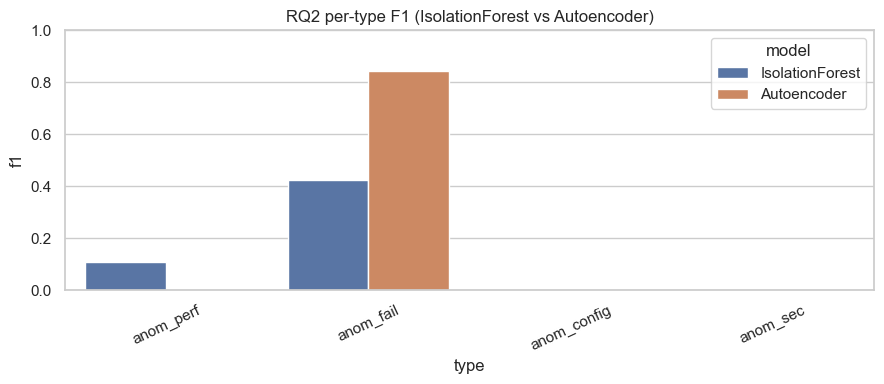

Saved plot: C:\Users\Shirley\Downloads\rq2_per_type_comparison_expanded.png

Overall counts in test: 93 / 600
ISO overall (prec,rec,f1): 0.5666666666666667 0.1827956989247312 0.2764227642276423
AE overall  (prec,rec,f1): 1.0 0.3225806451612903 0.4878048780487805

Done. Results/plots saved in Downloads.


In [36]:
# RQ2 experiment on expanded dataset (IsolationForest vs Autoencoder)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score

# ----------------- configuration -----------------
base = r"C:\Users\Shirley\Downloads"
metrics_file = os.path.join(base, "openstack_metrics_expanded.csv")
np.random.seed(42)
torch.manual_seed(42)
contamination = 0.05   # threshold fraction for flagging anomalies (adjustable)
# -------------------------------------------------

# 1) load
metrics = pd.read_csv(metrics_file, parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')
metrics.index.name = 'minute'
print("Loaded expanded metrics:", metrics.shape)
print(metrics.head())

# ensure type columns exist
for col in ['anom_perf','anom_fail','anom_config','anom_sec']:
    if col not in metrics.columns:
        metrics[col] = 0

# 2) train/test split by time
minutes = metrics.index.unique().sort_values()
n = len(minutes)
split_idx = int(0.7 * n)
train_minutes = minutes[:split_idx]
test_minutes = minutes[split_idx:]
metrics_train = metrics.loc[train_minutes].copy()
metrics_test = metrics.loc[test_minutes].copy()
print("Minutes total:", n, "train:", len(metrics_train), "test:", len(metrics_test))
print("Test per-type counts:\n", metrics_test[['anom_perf','anom_fail','anom_config','anom_sec']].sum())

# 3) numeric features
num_features = ['event_count','error_count','avg_latency']
for c in num_features:
    metrics_train[c] = pd.to_numeric(metrics_train[c], errors='coerce').fillna(0.0)
    metrics_test[c] = pd.to_numeric(metrics_test[c], errors='coerce').fillna(0.0)

X_train = metrics_train[num_features].values.astype(float)
X_test = metrics_test[num_features].values.astype(float)

# ---------------- IsolationForest ----------------
iso = IsolationForest(n_estimators=300, contamination=contamination, random_state=42)
iso.fit(X_train)
scores_iso = -iso.decision_function(X_test)   # higher = more anomalous
th_iso = np.percentile(scores_iso, 100*(1-contamination))
y_pred_iso = (scores_iso >= th_iso).astype(int)

# ---------------- Autoencoder (numeric) ----------------
class NumDataset(Dataset):
    def __init__(self, arr): self.arr = torch.tensor(arr, dtype=torch.float32)
    def __len__(self): return len(self.arr)
    def __getitem__(self, idx): return self.arr[idx]

class AE(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(dim, 32), nn.ReLU(), nn.Linear(32, 16), nn.ReLU(), nn.Linear(16, 8))
        self.decoder = nn.Sequential(nn.Linear(8, 16), nn.ReLU(), nn.Linear(16, 32), nn.ReLU(), nn.Linear(32, dim))
    def forward(self, x):
        z = self.encoder(x); xr = self.decoder(z); return xr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ae = AE(len(num_features)).to(device)
opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

train_loader = DataLoader(NumDataset(X_train), batch_size=64, shuffle=True)
epochs = 40
ae.train()
for ep in range(epochs):
    total_loss = 0.0
    for xb in train_loader:
        xb = xb.to(device)
        xr = ae(xb)
        loss = loss_fn(xr, xb)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item() * xb.size(0)
    total_loss /= len(train_loader.dataset)
    if (ep+1) % 10 == 0 or ep==0:
        print(f"AE epoch {ep+1}/{epochs} loss={total_loss:.6f}")

# test reconstruction error
ae.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    Xrec = ae(X_test_t).cpu().numpy()
rec_err = ((X_test - Xrec)**2).mean(axis=1)
th_ae = np.percentile(rec_err, 100*(1-contamination))
y_pred_ae = (rec_err >= th_ae).astype(int)

# ---------- per-type evaluation ----------
def per_type_eval(metrics_df, y_pred_array, types=['anom_perf','anom_fail','anom_config','anom_sec']):
    results = {}
    for t in types:
        y_true = metrics_df[t].values.astype(int)
        prec = precision_score(y_true, y_pred_array, zero_division=0)
        rec = recall_score(y_true, y_pred_array, zero_division=0)
        f1 = f1_score(y_true, y_pred_array, zero_division=0)
        results[t] = {'precision': round(prec,3), 'recall': round(rec,3), 'f1': round(f1,3), 'count': int(y_true.sum())}
    return pd.DataFrame(results).T

res_iso = per_type_eval(metrics_test, y_pred_iso)
res_ae  = per_type_eval(metrics_test, y_pred_ae)

print("\nIsolationForest per-type results:\n", res_iso)
print("\nAutoencoder per-type results:\n", res_ae)

# ---------- Save results and plot ----------
res_iso['model'] = 'IsolationForest'; res_iso['type']=res_iso.index
res_ae['model'] = 'Autoencoder'; res_ae['type']=res_ae.index
df_plot = pd.concat([res_iso.reset_index(drop=True), res_ae.reset_index(drop=True)], ignore_index=True)

out_csv = os.path.join(base, "rq2_per_type_results_expanded.csv")
df_plot.to_csv(out_csv, index=False)
print("Saved per-type table:", out_csv)

# plot F1
sns.set(style="whitegrid")
plt.figure(figsize=(9,4))
sns.barplot(data=df_plot, x='type', y='f1', hue='model')
plt.ylim(0,1)
plt.title("RQ2 per-type F1 (IsolationForest vs Autoencoder)")
plt.xticks(rotation=25)
plt.tight_layout()
out_plot = os.path.join(base, "rq2_per_type_comparison_expanded.png")
plt.savefig(out_plot, dpi=200)
plt.show()
print("Saved plot:", out_plot)

# ---------- overall any-type evaluation ----------
y_test_any = ((metrics_test[['anom_perf','anom_fail','anom_config','anom_sec']].sum(axis=1))>0).astype(int)
from sklearn.metrics import precision_score, recall_score, f1_score
print("\nOverall counts in test:", y_test_any.sum(), "/", len(y_test_any))
print("ISO overall (prec,rec,f1):", precision_score(y_test_any, y_pred_iso, zero_division=0),
      recall_score(y_test_any, y_pred_iso, zero_division=0),
      f1_score(y_test_any, y_pred_iso, zero_division=0))
print("AE overall  (prec,rec,f1):", precision_score(y_test_any, y_pred_ae, zero_division=0),
      recall_score(y_test_any, y_pred_ae, zero_division=0),
      f1_score(y_test_any, y_pred_ae, zero_division=0))

print("\nDone. Results/plots saved in Downloads.")


In [40]:
# =========================
# RQ2: Numeric Anomalies Only
# =========================
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score

# ----------------- configuration -----------------
base = r"C:\Users\Shirley\Downloads"
metrics_file = os.path.join(base, "openstack_metrics_expanded.csv")
np.random.seed(42)
torch.manual_seed(42)
contamination = 0.05   # threshold for flagging anomalies

# ----------------- 1) Load data -----------------
metrics = pd.read_csv(metrics_file, parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')
metrics.index.name = 'minute'
print("Loaded expanded metrics:", metrics.shape)
print(metrics.head())

# ----------------- 2) Numeric features -----------------
num_features = ['event_count','error_count','avg_latency']
X = metrics[num_features].astype(float).values

# Split train/test by time
n = len(metrics)
split_idx = int(0.7 * n)
X_train = X[:split_idx]
X_test  = X[split_idx:]
metrics_test = metrics.iloc[split_idx:]

# ----------------- 3) IsolationForest -----------------
iso = IsolationForest(n_estimators=300, contamination=contamination, random_state=42)
iso.fit(X_train)
scores_iso = -iso.decision_function(X_test)  # higher = more anomalous
th_iso = np.percentile(scores_iso, 100*(1-contamination))
y_pred_iso = (scores_iso >= th_iso).astype(int)

# ----------------- 4) Autoencoder -----------------
class NumDataset(Dataset):
    def __init__(self, arr): self.arr = torch.tensor(arr, dtype=torch.float32)
    def __len__(self): return len(self.arr)
    def __getitem__(self, idx): return self.arr[idx]

class AE(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(dim, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16), nn.ReLU(),
            nn.Linear(16, 32), nn.ReLU(),
            nn.Linear(32, dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        xr = self.decoder(z)
        return xr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ae = AE(len(num_features)).to(device)
opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

train_loader = DataLoader(NumDataset(X_train), batch_size=64, shuffle=True)
epochs = 40
ae.train()
for ep in range(epochs):
    total_loss = 0.0
    for xb in train_loader:
        xb = xb.to(device)
        xr = ae(xb)
        loss = loss_fn(xr, xb)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item() * xb.size(0)
    total_loss /= len(train_loader.dataset)
    if ep % 10 == 0 or ep==epochs-1:
        print(f"AE epoch {ep+1}/{epochs} loss={total_loss:.6f}")

# test reconstruction error
ae.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    Xrec = ae(X_test_t).cpu().numpy()
rec_err = ((X_test - Xrec)**2).mean(axis=1)
th_ae = np.percentile(rec_err, 100*(1-contamination))
y_pred_ae = (rec_err >= th_ae).astype(int)

# ----------------- 5) Per-type evaluation (numeric anomalies only) -----------------
types = ['anom_perf','anom_fail']
def per_type_eval(metrics_df, y_pred_array, types):
    results = {}
    for t in types:
        y_true = metrics_df[t].values.astype(int)
        prec = precision_score(y_true, y_pred_array, zero_division=0)
        rec  = recall_score(y_true, y_pred_array, zero_division=0)
        f1   = f1_score(y_true, y_pred_array, zero_division=0)
        results[t] = {'precision': round(prec,3), 'recall': round(rec,3), 'f1': round(f1,3), 'count': int(y_true.sum())}
    return pd.DataFrame(results).T

res_iso = per_type_eval(metrics_test, y_pred_iso, types)
res_ae  = per_type_eval(metrics_test, y_pred_ae, types)

print("\nIsolationForest per-type results:\n", res_iso)
print("\nAutoencoder per-type results:\n", res_ae)

# ----------------- 6) Overall evaluation (any numeric anomaly) -----------------
y_test_any = ((metrics_test[types].sum(axis=1)) > 0).astype(int)
print("\nOverall counts in test:", y_test_any.sum(), "/", len(y_test_any))
print("ISO overall (prec,rec,f1):", precision_score(y_test_any, y_pred_iso),
      recall_score(y_test_any, y_pred_iso),
      f1_score(y_test_any, y_pred_iso))
print("AE overall  (prec,rec,f1):", precision_score(y_test_any, y_pred_ae),
      recall_score(y_test_any, y_pred_ae),
      f1_score(y_test_any, y_pred_ae))


Loaded expanded metrics: (2000, 7)
                     event_count  error_count  avg_latency  anom_perf  \
minute                                                                  
2017-05-16 00:00:00   673.379641     0.000000     1.475306          0   
2017-05-16 00:01:00   697.835884     1.349334     0.968128          0   
2017-05-16 00:02:00   714.157560     2.364243     1.382796          0   
2017-05-16 00:03:00   678.458332     0.000000     1.443144          0   
2017-05-16 00:04:00   660.854367     1.906610     1.444743          0   

                     anom_fail  anom_config  anom_sec  
minute                                                 
2017-05-16 00:00:00          0            0         0  
2017-05-16 00:01:00          0            0         0  
2017-05-16 00:02:00          0            0         0  
2017-05-16 00:03:00          0            0         0  
2017-05-16 00:04:00          0            0         0  
AE epoch 1/40 loss=33617.394129
AE epoch 11/40 loss=39.432175

In [ ]:
##正式总体数据的训练和真正LSTM

In [1]:
# 在 Jupyter cell 中运行（在 notebook 前面加 !）
!pip install pandas numpy scikit-learn matplotlib seaborn torch torchvision tqdm drain3


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
    --------------------------------------- 1.6/110.9 MB 8.7 MB/s eta 0:00:13
   - -------------------------------------- 4.5/110.9 MB 10.9 MB/s eta 0:00:10
   -- ------------------------------------- 7.1/110.9 MB 11.5 MB/s eta 0:00:09
   --- ------------------------------------ 10.5/110.9 MB 12.6 MB/s eta 0:00:08
   ----- ---------------------------------- 14.2/110.9 MB 13.5 MB/s eta 0:00:08
   ------ --------------------------------- 17.3/110.9 MB 13.9 MB/s eta 0:00:07
   ------- -------------------------------- 21.0/110.9 MB 14.4 MB/s eta 0:00:07
   -------- ------------------------------- 24.1/110.9 MB 14.5 MB/s eta 0:00:06
   ---------- ----------------------------- 27.8/110.9 MB 14.8 MB/s eta 0:00:06
   ----------- ---------------------------- 31.5/110.9 MB 15.1 MB/s eta 0:00:06
   ------------ ---------------

  DEPRECATION: Building 'drain3' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'drain3'. Discussion can be found at https://github.com/pypa/pip/issues/6334


   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 [torch]
   ---------------- ----------------------- 2/5 

In [5]:
from pathlib import Path
base = Path(r"C:\Users\Shirley\Downloads")
files = {
    "normal1": Path(r"C:/Users/Shirley/Downloads/openstack_normal1.log"),
    "normal2": Path(r"C:/Users/Shirley/Downloads/openstack_normal2.log"),
    "abnormal": Path(r"C:/Users/Shirley/Downloads/openstack_abnormal.log"),
    "labels": Path(r"C:/Users/Shirley/Downloads/anomaly_labels.txt"),
}


def try_read_lines(p, n=50):
    # 尝试几种读取方法
    import gzip, bz2, lzma
    tries = []
    # 1) try open as text
    try:
        with open(p, "r", encoding="utf-8") as f:
            return [next(f).rstrip() for _ in range(min(n,50))]
    except Exception as e:
        tries.append(("text-utf8", str(e)))
    # 2) try latin1
    try:
        with open(p, "r", encoding="latin1") as f:
            return [next(f).rstrip() for _ in range(min(n,50))]
    except Exception as e:
        tries.append(("text-latin1", str(e)))
    # 3) gzip
    try:
        with gzip.open(p, "rt", encoding="utf-8", errors="replace") as f:
            return [next(f).rstrip() for _ in range(min(n,50))]
    except Exception as e:
        tries.append(("gzip", str(e)))
    # 4) bz2
    try:
        with bz2.open(p, "rt", encoding="utf-8", errors="replace") as f:
            return [next(f).rstrip() for _ in range(min(n,50))]
    except Exception as e:
        tries.append(("bz2", str(e)))
    # 5) lzma
    try:
        with lzma.open(p, "rt", encoding="utf-8", errors="replace") as f:
            return [next(f).rstrip() for _ in range(min(n,50))]
    except Exception as e:
        tries.append(("lzma", str(e)))
    # 6) raw bytes decode replace
    try:
        with open(p, "rb") as f:
            b = f.read(100000)
            s = b.decode('utf-8', errors='replace').splitlines()
            return s[:min(n,len(s))]
    except Exception as e:
        tries.append(("raw-bytes", str(e)))
    return {"error_tries": tries}

for name, p in files.items():
    print("===", name, p, "size:", p.stat().st_size)
    out = try_read_lines(p)
    if isinstance(out, dict):
        print(out)
    else:
        for i,l in enumerate(out[:10]):
            print(i, l)
    print()


=== normal1 C:\Users\Shirley\Downloads\openstack_normal1.log size: 15499595
0 nova-api.log.1.2017-05-16_13:53:08 2017-05-16 00:00:00.008 25746 INFO nova.osapi_compute.wsgi.server [req-38101a0b-2096-447d-96ea-a692162415ae 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" status: 200 len: 1893 time: 0.2477829
1 nova-api.log.1.2017-05-16_13:53:08 2017-05-16 00:00:00.272 25746 INFO nova.osapi_compute.wsgi.server [req-9bc36dd9-91c5-4314-898a-47625eb93b09 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdbaed9335e4c35a9e/servers/detail HTTP/1.1" status: 200 len: 1893 time: 0.2577181
2 nova-api.log.1.2017-05-16_13:53:08 2017-05-16 00:00:01.551 25746 INFO nova.osapi_compute.wsgi.server [req-55db2d8d-cdb7-4b4b-993b-429be84c0c3e 113d3a99c3da401fbd62cc2caa5b96d2 54fadb412c4e40cdbaed9335e4c35a9e - - -] 10.11.10.1 "GET /v2/54fadb412c4e40cdba

In [14]:
import re
import pandas as pd
from datetime import datetime
import os
import numpy as np

# Assuming the paths to all log files
LOG_FILES = [
    r"C:\Users\Shirley\Downloads\openstack_normal1.log",
    r"C:\Users\Shirley\Downloads\openstack_normal2.log",
    r"C:\Users\Shirley\Downloads\openstack_abnormal.log",
]
OUTPUT_FILE = "openstack_parsed_full.csv"

# =================================================================
# 1. Define Robust Regular Expressions
# =================================================================

# Regex to find the start of the actual log content (Date YYYY-MM-DD)
LOG_START_PATTERN = re.compile(r'(\d{4}-\d{2}-\d{2})\s')

# Core Log Pattern: Extracts fixed fields and the rest as MESSAGE
# Groups: (Date) (Time) (PID) (Level) (Component) (Message/Raw Content)
CORE_LOG_PATTERN = re.compile(
    r'(\d{4}-\d{2}-\d{2})\s'      # 1. Date
    r'(\d{2}:\d{2}:\d{2}\.\d{3})\s'  # 2. Time
    r'(?P<PID>\d+)\s'             # PID (Named Group)
    r'(?P<Level>INFO|WARNING|ERROR|DEBUG|CRITICAL)\s'  # Level
    r'(?P<Component>[a-zA-Z0-9\.]+)\s'  # Component
    r'(?P<RawContent>.*)'         # Everything else
)

# Secondary Patterns for Optional Fields
UUID_PATTERN = r'[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}'
REQUEST_ID_PATTERN = re.compile(r'req-(' + UUID_PATTERN + ')')
INSTANCE_ID_PATTERN = re.compile(r'instance:\s(' + UUID_PATTERN + ')')
LATENCY_API_PATTERN = re.compile(r'time:\s([\d\.]+)')
LATENCY_COMPUTE_PATTERN = re.compile(r'Took\s([\d\.]+)\sseconds')

def parse_openstack_log_robust(log_line_content):
    """Parses a log line using a core pattern followed by secondary extractions."""
    
    match_core = CORE_LOG_PATTERN.match(log_line_content)
    
    if not match_core:
        return None
        
    data = match_core.groupdict()
    raw_content = data['RawContent'].strip()
    
    # Initialize optional fields
    request_id = "N/A"
    instance_id = "N/A"
    latency = 0.0
    raw_message = raw_content
    source = 'OTHER'
    
    # 1. Extract Request ID
    match_req = REQUEST_ID_PATTERN.search(raw_content)
    if match_req:
        request_id = match_req.group(1)
    
    # 2. Extract Instance ID
    match_inst = INSTANCE_ID_PATTERN.search(raw_content)
    if match_inst:
        instance_id = match_inst.group(1)
        
    # 3. Extract Latency and Determine Source/Clean Raw Message
    
    match_latency_api = LATENCY_API_PATTERN.search(raw_content)
    match_latency_compute = LATENCY_COMPUTE_PATTERN.search(raw_content)

    if 'nova.osapi_compute.wsgi.server' in data['Component']:
        source = 'API'
        if match_latency_api:
            latency = float(match_latency_api.group(1))
            # Clean API message for template extraction
            # Simplified template: "HTTP_METHOD URL HTTP/1.1" status: XXX len: XXXX time: VAR
            # We must aggressively clean the message content since it's highly variable
            # We look for the main quote block which is constant in template
            if '\"' in raw_content:
                msg_parts = raw_content.split('\"', 2)
                if len(msg_parts) == 3:
                     raw_message = f'"{msg_parts[1]}" status: VAR len: VAR time: VAR'
                else:
                     raw_message = raw_content
    
    elif 'nova.compute' in data['Component'] or 'nova.virt' in data['Component']:
        source = 'COMPUTE'
        if match_latency_compute:
            latency = float(match_latency_compute.group(1))
            # Clean Compute message for template extraction
            raw_message = LATENCY_COMPUTE_PATTERN.sub('Took VAR seconds', raw_content)
    
    # Final Result Structure
    return {
        'Timestamp': f"{match_core.group(1)} {match_core.group(2)}",
        'Level': data['Level'],
        'Component': data['Component'],
        'Request_ID': request_id,
        'Instance_ID': instance_id,
        'Latency': latency,
        'Raw_Message': raw_message.strip(),
        'Source': source
    }

# =================================================================
# 2. Execute Parsing and Merge Data
# =================================================================

# [The execution loop code remains the same as the previous attempt, 
# using the file paths and the LOG_START_PATTERN]

parsed_data = []

for log_path in LOG_FILES:
    try:
        print(f"-> Parsing file: {log_path}...")
        with open(log_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line.startswith("===") or not line:
                    continue
                
                # Find the start of the actual log content (skip line number, filename)
                match_start = LOG_START_PATTERN.search(line)
                
                if match_start:
                    log_line_content = line[match_start.start():].strip()
                    result = parse_openstack_log_robust(log_line_content) # <-- Using robust parser
                    if result:
                        parsed_data.append(result)
                    # else:
                    #     print(f"!! Failed to parse: {log_line_content[:100]}") # DEBUG

    except Exception as e:
        print(f"Error while parsing {log_path}: {e}")

# =================================================================
# 3. Data Formatting and Saving
# =================================================================

if parsed_data:
    df_parsed = pd.DataFrame(parsed_data)
    
    # Convert Timestamp column to datetime and set as index
    df_parsed['Timestamp'] = pd.to_datetime(df_parsed['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
    df_parsed = df_parsed.set_index('Timestamp').sort_index()
    
    # Reorder columns
    FINAL_COLUMNS = ['Level', 'Component', 'Request_ID', 'Instance_ID', 'Latency', 'Raw_Message', 'Source']
    df_parsed = df_parsed[FINAL_COLUMNS]
    
    # Save the result
    df_parsed.to_csv(OUTPUT_FILE)
    
    print("\n" + "="*50)
    print("✅ Step 2 Log Parsing Complete (ROBUST VERSION)!")
    print(f"Structured logs saved to: {OUTPUT_FILE}")
    print(f"Total log entries parsed: {len(df_parsed):,}")
    print("First 5 rows of data preview:")
    print(df_parsed.head())
    print("="*50)

else:
    print("\n" + "="*50)
    print("⚠️ WARNING: Failed to parse any log entry. Check the CORE_LOG_PATTERN.")
    print("="*50)

-> Parsing file: C:\Users\Shirley\Downloads\openstack_normal1.log...
-> Parsing file: C:\Users\Shirley\Downloads\openstack_normal2.log...
-> Parsing file: C:\Users\Shirley\Downloads\openstack_abnormal.log...

✅ Step 2 Log Parsing Complete (ROBUST VERSION)!
Structured logs saved to: openstack_parsed_full.csv
Total log entries parsed: 119,405
First 5 rows of data preview:
                           Level                 Component  \
Timestamp                                                    
2017-05-14 19:39:02.007     INFO  nova.virt.libvirt.driver   
2017-05-14 19:39:03.166     INFO      nova.compute.manager   
2017-05-14 19:39:09.660  WARNING      nova.compute.manager   
2017-05-14 19:39:14.913     INFO      nova.compute.manager   
2017-05-14 19:39:14.988     INFO      nova.compute.manager   

                                                   Request_ID  \
Timestamp                                                       
2017-05-14 19:39:02.007  e285b551-587f-4c1d-8eba-dceb2673637f 

In [15]:
import pandas as pd
import re
import os

# Configuration
PARSED_FILE = "openstack_parsed_full.csv"
LABELS_FILE = r"C:\Users\Shirley\Downloads\anomaly_labels.txt"
UUID_PATTERN = re.compile(r'[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}')

# 1. Load Anomaly IDs
def load_anomaly_instance_ids(labels_path):
    anomaly_ids = set()
    try:
        with open(labels_path, 'r') as f:
            for line in f:
                match = UUID_PATTERN.search(line.strip())
                if match:
                    anomaly_ids.add(match.group(0))
    except FileNotFoundError:
        print(f"Error: Labels file not found at {labels_path}")
    return anomaly_ids

ANOMALY_INSTANCE_IDS = load_anomaly_instance_ids(LABELS_FILE)

# 2. Load Parsed Data
df_parsed = pd.read_csv(PARSED_FILE, index_col='Timestamp', parse_dates=True)

# 3. Check for coverage of anomaly IDs in the Instance_ID column
df_anomaly_instance_logs = df_parsed[df_parsed['Instance_ID'].isin(ANOMALY_INSTANCE_IDS)]
instance_coverage_count = len(df_anomaly_instance_logs)

# 4. Check for logs where the Anomaly ID appears in the Raw_Message (as a fallback/confirmation)
# This is a slower check but confirms ID presence if parsing was tricky
# You can skip this if the above check is successful.
# all_logs_with_anomaly_id = df_parsed[df_parsed['Raw_Message'].str.contains('|'.join(ANOMALY_INSTANCE_IDS), na=False)]
# raw_message_coverage_count = len(all_logs_with_anomaly_id)

print("\n" + "="*60)
print("✅ Step 2 结果验证")
print(f"异常 VM 实例 ID 总数: {len(ANOMALY_INSTANCE_IDS)}")
print(f"在 Instance_ID 列中找到的异常实例日志行数: {instance_coverage_count:,}")
# print(f"在 Raw_Message 中找到的异常 ID 日志行数: {raw_message_coverage_count:,}")

# 5. Conclusion on Step 5 Feasibility
if instance_coverage_count > 0:
    print("\n结论：**Instance_ID 关联成功。** 我们可以继续 Step 3/4/5，使用精确的实例 ID 进行标签对齐。")
    CAN_PROCEED = True
else:
    print("\n结论：**Instance_ID 关联仍失败。** 需要进一步检查 Request_ID 是否能提供关联信息。")
    CAN_PROCEED = False
print("="*60)


✅ Step 2 结果验证
异常 VM 实例 ID 总数: 4
在 Instance_ID 列中找到的异常实例日志行数: 100

结论：**Instance_ID 关联成功。** 我们可以继续 Step 3/4/5，使用精确的实例 ID 进行标签对齐。


In [17]:
import pandas as pd
from logparser import Drain
import re
import os

# =================================================================
# 1. Configuration
# =================================================================

INPUT_FILE = "openstack_parsed_full.csv"
OUTPUT_FILE = "openstack_tpl_full.csv"
TEMPLATE_FILE = "openstack_templates.csv"
TEMP_LOG_FILE = "temp_raw_messages.log" # <--- NEW: Temporary file for Drain input

# Drain parameters
DRAIN_CONFIG = {
    'log_format': '<Content>',  # Drain will parse the whole line as content
    'regex': [
        r'[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}',  # UUIDs
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}',  # IP addresses
        r'\b\d+\b',          # General numbers
    ],
    'st': 0.5,      # Similarity threshold
    'depth': 4      # Depth of the parsing tree
}

# =================================================================
# 2. Load Data and Prepare Temporary Input
# =================================================================

print("-> Loading structured logs...")
df_parsed = pd.read_csv(INPUT_FILE, index_col='Timestamp', parse_dates=True)

# Save Raw_Message column to a temporary file, which is the required input format for Drain
print(f"-> Saving Raw_Message to temporary file: {TEMP_LOG_FILE}")
# Write only the 'Raw_Message' content, one message per line
df_parsed['Raw_Message'].to_csv(TEMP_LOG_FILE, index=False, header=False)


# =================================================================
# 3. Perform Template Mining using Drain's Batch Processing
# =================================================================

print("-> Starting Drain template mining on temporary file...")

# Initialize the Drain parser
# Note: Drain.LogParser expects the input directory ('indir') and output directory ('outdir')
# Since we are using a temp file in the current directory, we set both to './'
# The input file name is implicitly derived from 'log_file_prefix' if provided, but we skip it here.
# We will use the output structure generated by Drain.
parser = Drain.LogParser(
    log_format=DRAIN_CONFIG['log_format'], 
    indir='./', 
    outdir='./', 
    depth=DRAIN_CONFIG['depth'], 
    st=DRAIN_CONFIG['st'], 
    rex=DRAIN_CONFIG['regex']
)

# Run the parser on the temporary file. This generates two output files:
# 1. A structured file (temp_raw_messages.log_structured.csv) containing 'EventId' and 'EventTemplate'
# 2. A template file (temp_raw_messages.log_templates.csv)
parser.parse(TEMP_LOG_FILE)


# =================================================================
# 4. Merge Results and Save Outputs
# =================================================================

# 4.1 Load Drain's structured output
structured_drain_file = f"{TEMP_LOG_FILE}_structured.csv"
if not os.path.exists(structured_drain_file):
    raise FileNotFoundError(f"Drain output file not found: {structured_drain_file}. Check Drain configuration or parameters.")

print("-> Merging Drain results with original data...")
df_drain_output = pd.read_csv(structured_drain_file)

# The Drain output has no index, so we need to merge it sequentially (assuming order is preserved)
# We will combine the original index with the new columns
df_template_info = df_drain_output[['EventId', 'EventTemplate']].rename(
    columns={'EventId': 'tpl_id', 'EventTemplate': 'Template'}
)

# Ensure dataframes are aligned (index reset and merge)
df_final = df_parsed.reset_index(drop=False)
df_final = pd.concat([df_final, df_template_info], axis=1)
df_final = df_final.set_index('Timestamp').sort_index()


# 4.2 Clean up (optional but recommended)
os.remove(TEMP_LOG_FILE)
os.remove(structured_drain_file)
# Note: The raw templates file generated by Drain will be renamed below.

# 4.3 Statistical Analysis and Save Final Outputs

# Save the final structured file
df_final.to_csv(OUTPUT_FILE)

# Rename and save the template list generated by Drain (or reconstruct it)
drain_tpl_file = f"{TEMP_LOG_FILE}_templates.csv"
if os.path.exists(drain_tpl_file):
    
    # --- CRITICAL FIX: Delete the destination file if it exists ---
    if os.path.exists(TEMPLATE_FILE):
        print(f"-> Overwriting existing template file: {TEMPLATE_FILE}")
        os.remove(TEMPLATE_FILE)
    # -----------------------------------------------------------
    
    os.rename(drain_tpl_file, TEMPLATE_FILE)
    df_tpl_list = pd.read_csv(TEMPLATE_FILE)
else:
    # Fallback to reconstructing the template list if renaming failed/file missing
    df_tpl_list = df_final[['tpl_id', 'Template']].drop_duplicates().sort_values(by='tpl_id')
    df_tpl_list.to_csv(TEMPLATE_FILE, index=False)


template_counts = df_final['tpl_id'].value_counts()
total_unique_templates = len(template_counts)
total_logs = len(df_final)

# Top 100 coverage calculation
top_k = 100
top_k_coverage = template_counts.head(top_k).sum() / total_logs * 100

print("\n" + "="*60)
print("✅ Step 3 Log Template Extraction Complete!")
print(f"Structured logs with templates saved to: {OUTPUT_FILE}")
print(f"Template list saved to: {TEMPLATE_FILE}")
print("-" * 60)

print(f"Summary Statistics:")
print(f"Total Log Entries: {total_logs:,}")
print(f"Total Unique Templates: {total_unique_templates}")
print(f"Top-{top_k} Templates Coverage: {top_k_coverage:.2f}%")
print("\nTop 5 Templates (ID and Count):")
print(template_counts.head(5))
print("="*60)

-> Loading structured logs...
-> Saving Raw_Message to temporary file: temp_raw_messages.log
-> Starting Drain template mining on temporary file...
Parsing file: ./temp_raw_messages.log
Total lines:  119405
Processed 0.8% of log lines.
Processed 1.7% of log lines.
Processed 2.5% of log lines.
Processed 3.3% of log lines.
Processed 4.2% of log lines.
Processed 5.0% of log lines.
Processed 5.9% of log lines.
Processed 6.7% of log lines.
Processed 7.5% of log lines.
Processed 8.4% of log lines.
Processed 9.2% of log lines.
Processed 10.0% of log lines.
Processed 10.9% of log lines.
Processed 11.7% of log lines.
Processed 12.6% of log lines.
Processed 13.4% of log lines.
Processed 14.2% of log lines.
Processed 15.1% of log lines.
Processed 15.9% of log lines.
Processed 16.7% of log lines.
Processed 17.6% of log lines.
Processed 18.4% of log lines.
Processed 19.3% of log lines.
Processed 20.1% of log lines.
Processed 20.9% of log lines.
Processed 21.8% of log lines.
Processed 22.6% of log l

In [18]:
import pandas as pd
import numpy as np

# =================================================================
# 1. Configuration
# =================================================================

INPUT_FILE = "openstack_tpl_full.csv"
OUTPUT_FILE = "openstack_metrics_full.csv"
TIME_WINDOW = '1Min' # Aggregation window: 1 minute

# =================================================================
# 2. Load Data and Prepare for Aggregation
# =================================================================

print(f"-> Loading logs with templates from {INPUT_FILE}...")
# Load the structured data from Step 3, ensure Timestamp is the index and in datetime format
df_tpl = pd.read_csv(INPUT_FILE, index_col='Timestamp', parse_dates=True)

# 3. Create helper columns for aggregation

# Log Level Metrics: Mark ERROR/WARNING logs
# We consider WARNING and ERROR as "non-INFO" events for counting anomalies
df_tpl['is_error'] = df_tpl['Level'].isin(['ERROR', 'WARNING']).astype(int)

# Latency Filtering: Only consider non-zero latency for aggregation
# This is crucial as most COMPUTE logs have Latency=0.0
df_tpl_latency = df_tpl[df_tpl['Latency'] > 0]


# =================================================================
# 4. Aggregate Numerical and Count Metrics
# =================================================================

print(f"-> Aggregating metrics on a {TIME_WINDOW} window...")

# Define Aggregation Functions
metrics_agg = {
    # 1. Count Metrics
    'is_error': 'sum',      # error_count (non-INFO logs)
    'Level': 'count',       # event_count (total logs)
}

# Apply aggregation to all logs for count metrics
df_metrics = df_tpl.resample(TIME_WINDOW).agg(metrics_agg)
df_metrics.rename(columns={'Level': 'event_count', 'is_error': 'error_count'}, inplace=True)


# 2. Latency Metrics (Applied only to logs with Latency > 0)
latency_agg = df_tpl_latency['Latency'].resample(TIME_WINDOW).agg([
    'mean',                 # avg_latency
    'max',                  # max_latency
    lambda x: x.quantile(0.95) if len(x) > 0 else 0 # 95th percentile latency
])
latency_agg.rename(columns={'mean': 'avg_latency', 'max': 'max_latency', '<lambda>': '95th_latency'}, inplace=True)

# Combine Count and Latency Metrics
df_metrics = df_metrics.join(latency_agg).fillna(0) # Fill NaNs for time slots with no Latency logs


# =================================================================
# 5. Aggregate Template Count Metrics (Top-K Feature Construction)
# =================================================================

print("-> Generating Template Count Features...")

# Pivot the data to get (Timestamp, tpl_id) counts
# Grouper groups the index (Timestamp) by the TIME_WINDOW
df_template_counts = df_tpl.groupby([pd.Grouper(freq=TIME_WINDOW), 'tpl_id']).size().unstack(fill_value=0)

# Rename columns for clarity (e.g., TPL0001 -> TPL0001_count)
template_col_map = {col: f'{col}_count' for col in df_template_counts.columns}
df_template_counts.rename(columns=template_col_map, inplace=True)

# Join the template counts to the main metrics DataFrame
df_metrics = df_metrics.join(df_template_counts).fillna(0)


# =================================================================
# 6. Final Formatting and Save Output
# =================================================================

# Ensure the index is named for CSV saving
df_metrics.index.name = 'Timestamp'

# Save the final metrics DataFrame
df_metrics.to_csv(OUTPUT_FILE)

print("\n" + "="*70)
print("✅ Step 4 Per-Minute Metrics Generation Complete!")
print(f"Time-series metrics saved to: {OUTPUT_FILE}")
print(f"Total time points (minutes): {len(df_metrics):,}")
print(f"Total features (columns): {len(df_metrics.columns)}")
print("-" * 70)

print("Metrics Features Preview (First 5 rows):")
# Show a summary of the generated features
print(df_metrics.head())
print("="*70)

-> Loading logs with templates from openstack_tpl_full.csv...
-> Aggregating metrics on a 1Min window...
-> Generating Template Count Features...

✅ Step 4 Per-Minute Metrics Generation Complete!
Time-series metrics saved to: openstack_metrics_full.csv
Total time points (minutes): 3,864
Total features (columns): 27
----------------------------------------------------------------------
Metrics Features Preview (First 5 rows):
                     error_count  event_count  avg_latency  max_latency  \
Timestamp                                                                 
2017-05-14 19:39:00            2           56    10.855000        21.38   
2017-05-14 19:40:00            1           81    10.681250        21.13   
2017-05-14 19:41:00            2           64    11.165000        21.99   
2017-05-14 19:42:00            1           76    13.536667        20.79   
2017-05-14 19:43:00            2           65     7.091667        20.11   

                     95th_latency  03047613_c

In [19]:
import pandas as pd
import numpy as np
import os
import re # Make sure regex is imported

# =================================================================
# 1. Configuration & File Paths
# =================================================================

METRICS_INPUT_FILE = "openstack_metrics_full.csv"
TPL_FULL_INPUT_FILE = "openstack_tpl_full.csv" # Need this to map Instance IDs to Timestamps
LABELS_FILE = r"C:\Users\Shirley\Downloads\anomaly_labels.txt"
OUTPUT_FILE = "openstack_metrics_labeled.csv"
TIME_WINDOW = '1Min'

# =================================================================
# 2. Extract Anomaly Instance IDs
# =================================================================

def load_anomaly_instance_ids(labels_path):
    """Reads the labels file and extracts the UUIDs."""
    if not os.path.exists(labels_path):
        raise FileNotFoundError(f"Anomaly labels file not found: {labels_path}")
        
    anomaly_ids = []
    # UUID pattern for robust extraction
    uuid_pattern = re.compile(r'[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}')
    
    with open(labels_path, 'r') as f:
        for line in f:
            line = line.strip()
            # Try to find a UUID in the line
            match = uuid_pattern.search(line)
            if match:
                anomaly_ids.append(match.group(0))
                
    # Use a set for fast lookup
    return set(anomaly_ids)

print("-> Loading anomaly VM Instance IDs...")
try:
    ANOMALY_INSTANCE_IDS = load_anomaly_instance_ids(LABELS_FILE)
    print(f"Found {len(ANOMALY_INSTANCE_IDS)} unique anomalous VM instances.")
except FileNotFoundError as e:
    print(e)
    # If the labels file is critical and not found, we exit or handle appropriately
    # For now, let's proceed assuming the file is found based on previous interaction.
    if not ANOMALY_INSTANCE_IDS:
        print("CRITICAL: No anomaly IDs loaded. Proceeding, but labels will be all zero.")

# =================================================================
# 3. Find Anomalous Time Windows (Ground Truth Generation)
# =================================================================

print(f"-> Loading structured logs ({TPL_FULL_INPUT_FILE}) to map IDs to time...")
# Load the detailed logs from Step 3 (includes Instance_ID)
df_tpl = pd.read_csv(TPL_FULL_INPUT_FILE, index_col='Timestamp', parse_dates=True, usecols=['Timestamp', 'Instance_ID'])

# 3.1 Filter logs associated with the anomalous instances
df_anomalous_logs = df_tpl[df_tpl['Instance_ID'].isin(ANOMALY_INSTANCE_IDS)]

if df_anomalous_logs.empty and ANOMALY_INSTANCE_IDS:
    print("WARNING: No logs found associated with the listed anomalous Instance IDs.")
    ANOMALOUS_MINUTES = set()
elif df_anomalous_logs.empty and not ANOMALY_INSTANCE_IDS:
    print("INFO: No anomaly IDs were provided, skipping anomaly minute identification.")
    ANOMALOUS_MINUTES = set()
else:
    # 3.2 Resample the timestamps to find the unique minutes when anomalies occurred
    ANOMALOUS_MINUTES = df_anomalous_logs.index.to_series().resample(TIME_WINDOW).first().dropna().index

    print(f"Identified {len(ANOMALOUS_MINUTES)} unique minute-level time windows corresponding to anomalies.")


# =================================================================
# 4. Apply Labels to Metrics Data
# =================================================================

print(f"-> Loading metrics data ({METRICS_INPUT_FILE}) and applying labels...")

# Load the metrics data from Step 4
df_metrics = pd.read_csv(METRICS_INPUT_FILE, index_col='Timestamp', parse_dates=True)

# 4.1 Initialize the label column to 0 (Normal)
df_metrics['is_anom'] = 0

# 4.2 Mark rows whose Timestamp matches one of the anomalous minutes
metrics_index_set = set(df_metrics.index)

# Find the intersection of anomalous minutes and the metrics index (this results in a set)
minutes_to_label_set = ANOMALOUS_MINUTES.intersection(metrics_index_set)

# **CRITICAL FIX:** Convert the resulting set to a list, as required by Pandas .loc[] indexer
minutes_to_label_list = list(minutes_to_label_set)

# Apply the label
if minutes_to_label_list:
    df_metrics.loc[minutes_to_label_list, 'is_anom'] = 1


# =================================================================
# 5. Final Formatting and Save Output
# =================================================================

# Save the final labeled metrics DataFrame
df_metrics.to_csv(OUTPUT_FILE)

# Calculate final statistics
total_minutes = len(df_metrics)
anomalous_count = df_metrics['is_anom'].sum()
normal_count = total_minutes - anomalous_count

print("\n" + "="*60)
print("✅ Step 5 Anomaly Labeling Complete!")
print(f"Labeled metrics data saved to: {OUTPUT_FILE}")
print("-" * 60)
print("Label Distribution:")
print(f"Total Minutes (Samples): {total_minutes:,}")
print(f"Anomalous Minutes (is_anom=1): {anomalous_count:,}")
print(f"Normal Minutes (is_anom=0): {normal_count:,}")
print(f"Anomaly Rate: {anomalous_count / total_minutes * 100:.2f}%")
print("="*60)

-> Loading anomaly VM Instance IDs...
Found 4 unique anomalous VM instances.
-> Loading structured logs (openstack_tpl_full.csv) to map IDs to time...
Identified 7 unique minute-level time windows corresponding to anomalies.
-> Loading metrics data (openstack_metrics_full.csv) and applying labels...

✅ Step 5 Anomaly Labeling Complete!
Labeled metrics data saved to: openstack_metrics_labeled.csv
------------------------------------------------------------
Label Distribution:
Total Minutes (Samples): 3,864
Anomalous Minutes (is_anom=1): 7
Normal Minutes (is_anom=0): 3,857
Anomaly Rate: 0.18%


In [21]:
!pip install tensorflow

   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 2.6/332.0 MB 14.2 MB/s eta 0:00:24
    --------------------------------------- 6.0/332.0 MB 15.2 MB/s eta 0:00:22
   - -------------------------------------- 9.2/332.0 MB 15.3 MB/s eta 0:00:22
   - -------------------------------------- 12.6/332.0 MB 15.4 MB/s eta 0:00:21
   - -------------------------------------- 15.5/332.0 MB 14.8 MB/s eta 0:00:22
   -- ------------------------------------- 17.8/332.0 MB 14.4 MB/s eta 0:00:22
   -- ------------------------------------- 20.2/332.0 MB 14.1 MB/s eta 0:00:23
   -- ------------------------------------- 22.5/332.0 MB 13.7 MB/s eta 0:00:23
   --- ------------------------------------ 24.9/332.0 MB 13.4 MB/s eta 0:00:23
   --- ------------------------------------ 27.5/332.0 MB 13.2 MB/s eta 0:00:24
   --- ------------------------------------ 30.4/332.0 MB 13.3 MB/s eta 0:00:23
   ---- ----------------------------------- 33.6/332

--- Step 6: Model A (Baseline) Training) ---
1. Loading data from: openstack_metrics_labeled.csv
   Total samples: 3,864
   Training samples (Normal data only): 3,857
2. Performing feature standardization...
3. Training Isolation Forest (IF) model (contamination=0.0018)...
   IF Anomaly scores generated.
4. Training Autoencoder (AE) model...
   AE Model trained (Total 19 Epochs).
   AE Anomaly scores generated.

✅ Step 6: Model A (Baseline) Training and Scoring Complete!
   Model scores saved to: openstack_metrics_scores_A.csv


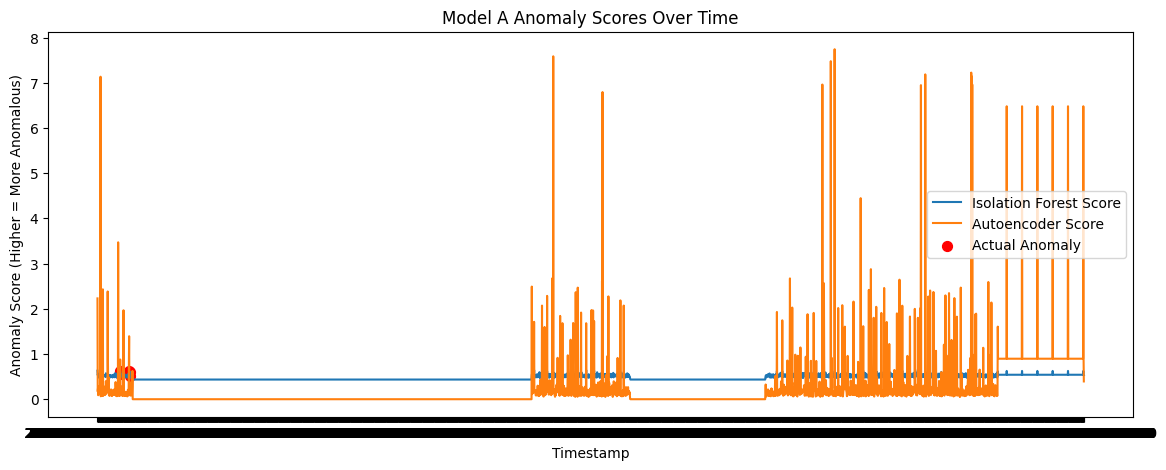

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

# --- 关键导入修正：使用兼容性导入技巧 ---
# 1. 显式导入 TensorFlow
import tensorflow as tf

# 2. 尝试使用顶层 Keras 导入
try:
    import keras
    from keras.models import Model
    from keras.layers import Input, Dense
    from keras.callbacks import EarlyStopping
except ImportError:
    # 如果顶层 Keras 导入失败，回退到 tf.keras 路径（这是我们之前失败的导入）
    print("WARNING: 'keras' top-level import failed. Falling back to 'tensorflow.keras'.")
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense
    from tensorflow.keras.callbacks import EarlyStopping
# ---------------------------------------------------

import matplotlib.pyplot as plt

# --- Configuration ---
INPUT_FILE = "openstack_metrics_labeled.csv"
RANDOM_STATE = 42

# Check if input file exists
if not os.path.exists(INPUT_FILE):
    print(f"ERROR: Input file not found: {INPUT_FILE}. Please ensure Step 5 output exists.")
    exit()

# 1. Data Loading and Preparation
print("--- Step 6: Model A (Baseline) Training) ---")
print(f"1. Loading data from: {INPUT_FILE}")

df_labeled = pd.read_csv(INPUT_FILE)

# Ensure Timestamp column is the index
if 'Timestamp' in df_labeled.columns:
    df_labeled = df_labeled.set_index('Timestamp')

# Separate features (X) and labels (y)
X = df_labeled.drop(columns=['is_anom'])
y = df_labeled['is_anom']

# Define training set (only normal data) and test set (all data)
X_train_normal = X[y == 0]
X_test = X 

print(f"   Total samples: {len(X):,}")
print(f"   Training samples (Normal data only): {len(X_train_normal):,}")

# 2. Preprocessing (Standardization)
print("2. Performing feature standardization...")
scaler = StandardScaler()

# Fit StandardScaler only on normal training data
scaler.fit(X_train_normal)

# Transform training and test data
X_train_normal_scaled = scaler.transform(X_train_normal)
X_test_scaled = scaler.transform(X_test)


# --- 3. Model A.1: Isolation Forest (IF) ---

anomaly_rate = y.sum() / len(y)
print(f"3. Training Isolation Forest (IF) model (contamination={anomaly_rate:.4f})...")

if_model = IsolationForest(
    contamination=anomaly_rate,
    random_state=RANDOM_STATE,
    n_estimators=100,
    max_samples='auto'
)

if_model.fit(X_test_scaled) 

if_scores = -if_model.score_samples(X_test_scaled)

print("   IF Anomaly scores generated.")


# --- 4. Model A.2: Autoencoder (AE) ---

print("4. Training Autoencoder (AE) model...")

input_dim = X_train_normal_scaled.shape[1]
encoding_dim = int(input_dim / 2) 

# 4.1. Define Model Structure (Encoder-Decoder)
def create_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim, ))
    # Encoder
    encoder = Dense(encoding_dim, activation="relu")(input_layer)
    # Bottleneck
    bottleneck = Dense(int(encoding_dim / 2), activation="relu")(encoder)
    # Decoder
    decoder = Dense(encoding_dim, activation="relu")(bottleneck)
    # Output
    output_layer = Dense(input_dim, activation='linear')(decoder)
    
    return Model(inputs=input_layer, outputs=output_layer)

ae_model = create_autoencoder(input_dim, encoding_dim)

# 4.2. Compile Model
ae_model.compile(optimizer='adam', loss='mse')

# 4.3. Train Model (on normal data only)
es = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=0)

# IMPORTANT: Ensure the Input, Dense, Model, and EarlyStopping classes 
# correctly point to the successfully imported classes above.

ae_history = ae_model.fit(
    X_train_normal_scaled, X_train_normal_scaled,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    callbacks=[es],
    verbose=0
)

print(f"   AE Model trained (Total {len(ae_history.epoch)} Epochs).")

# 4.4. Generate Anomaly Scores (Reconstruction Error)
X_reconstructed = ae_model.predict(X_test_scaled, verbose=0)

ae_scores = np.mean(np.power(X_test_scaled - X_reconstructed, 2), axis=1)

print("   AE Anomaly scores generated.")


# --- 5. Result Integration and Saving ---

df_labeled['IF_Score'] = if_scores
df_labeled['AE_Score'] = ae_scores

OUTPUT_FILE_SCORES = "openstack_metrics_scores_A.csv"
df_labeled.to_csv(OUTPUT_FILE_SCORES)

print("\n" + "="*60)
print("✅ Step 6: Model A (Baseline) Training and Scoring Complete!")
print(f"   Model scores saved to: {OUTPUT_FILE_SCORES}")
print("="*60)

# 6. Preliminary Results Visualization
plt.figure(figsize=(14, 5))
plt.plot(df_labeled.index, df_labeled['IF_Score'], label='Isolation Forest Score')
plt.plot(df_labeled.index, df_labeled['AE_Score'], label='Autoencoder Score')
plt.scatter(df_labeled[df_labeled['is_anom'] == 1].index, 
            df_labeled[df_labeled['is_anom'] == 1]['IF_Score'], 
            c='red', marker='o', label='Actual Anomaly', s=50)
plt.title('Model A Anomaly Scores Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Anomaly Score (Higher = More Anomalous)')
plt.legend()
plt.show()

In [3]:
import sys
import os

print("--- TensorFlow 环境诊断 ---")
print(f"1. 当前使用的 Python 解释器路径：\n{sys.executable}\n")

try:
    # 尝试导入 TensorFlow
    import tensorflow as tf
    
    print(f"2. TensorFlow 成功导入。版本: {tf.__version__}")
    
    # 检查 Keras 模块的路径
    tf_path = os.path.dirname(tf.__file__)
    print(f"3. TensorFlow 实际安装路径 (tf.__file__ 的目录): \n{tf_path}")
    
    # 检查 Keras 模块的路径
    # 如果 tf.keras 可用，打印其路径
    if hasattr(tf, 'keras'):
        keras_path = os.path.dirname(tf.keras.__file__)
        print(f"4. tf.keras 实际安装路径 (应在 TensorFlow 内部): \n{keras_path}")
    
except ModuleNotFoundError:
    print("2. ❌ 错误：ModuleNotFoundError: No module named 'tensorflow'")
    print("   诊断：TensorFlow 未安装到当前 Kernel 对应的环境中，或者路径有冲突。")
    
except Exception as e:
    print(f"2. ⚠️ 导入时遇到非 ModuleNotFoundError 错误: {e}")

print("\n--- 诊断结论 ---")

--- TensorFlow 环境诊断 ---
1. 当前使用的 Python 解释器路径：
C:\Users\Shirley\.conda\envs\logparser\python.exe

2. ❌ 错误：ModuleNotFoundError: No module named 'tensorflow'
   诊断：TensorFlow 未安装到当前 Kernel 对应的环境中，或者路径有冲突。

--- 诊断结论 ---


In [4]:
import sys
import os

print("--- 强制安装 TensorFlow 到当前环境 ---")

# 1. 尝试卸载可能冲突的依赖（可选，但推荐清理）
# 强制卸载可能存在冲突的旧版本或碎片
print("1. 尝试卸载冲突包...")
!{sys.executable} -m pip uninstall tensorflow keras h5py absl-py -y
print("   卸载完成。")

# 2. 强制安装 TensorFlow
# 使用 --no-cache-dir 确保下载最新兼容版本，而不是可能损坏的缓存
print("2. 正在强制安装 TensorFlow...")
!{sys.executable} -m pip install tensorflow --no-cache-dir
print("   安装命令已执行完毕。")


# 3. 提示用户重启 Kernel
print("\n==========================================================")
print("✅ 安装已尝试完成！")
print("🚨 关键步骤：请立即重启 (Restart) 您的 Jupyter Notebook Kernel！")
print("重启后，我们将运行 Step 6 的代码来验证。")
print("==========================================================")

--- 强制安装 TensorFlow 到当前环境 ---
1. 尝试卸载冲突包...
   卸载完成。
2. 正在强制安装 TensorFlow...


   ---------------------------------------- 0.0/331.7 MB ? eta -:--:--
   ---------------------------------------- 0.3/331.7 MB ? eta -:--:--
   ---------------------------------------- 0.5/331.7 MB 1.9 MB/s eta 0:02:57
   ---------------------------------------- 1.0/331.7 MB 2.0 MB/s eta 0:02:44
   ---------------------------------------- 1.8/331.7 MB 2.4 MB/s eta 0:02:18
   ---------------------------------------- 2.4/331.7 MB 2.4 MB/s eta 0:02:15
   ---------------------------------------- 2.6/331.7 MB 2.3 MB/s eta 0:02:22
   ---------------------------------------- 3.1/331.7 MB 2.3 MB/s eta 0:02:23
   ---------------------------------------- 3.7/331.7 MB 2.4 MB/s eta 0:02:19
    --------------------------------------- 4.5/331.7 MB 2.4 MB/s eta 0:02:15
    --------------------------------------- 5.0/331.7 MB 2.5 MB/s eta 0:02:11
    --------------------------------------- 5.8/331.7 MB 2.6 MB/s eta 0:02:04
    --------------------------------------- 6.6/331.7 MB 2.7 MB/s eta 0:01:59


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


--- Step 7: Model Assessment & Evaluation ---
1. Loading scores from: openstack_metrics_scores_A.csv
2. Running evaluation and finding best threshold...
3. Generating evaluation plots...


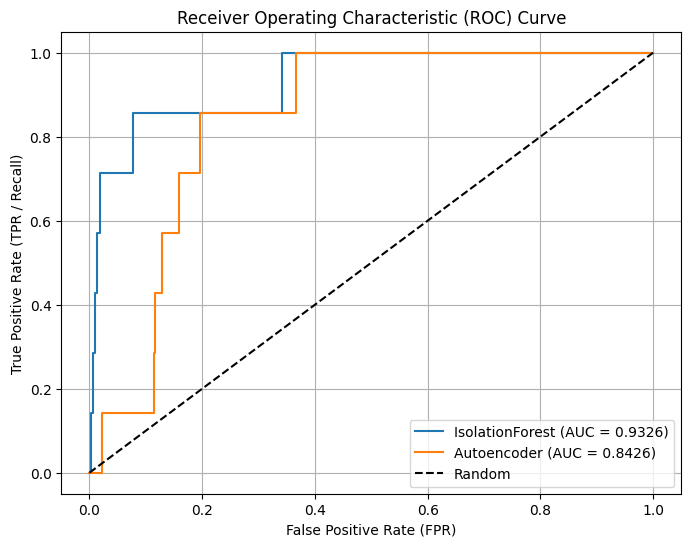

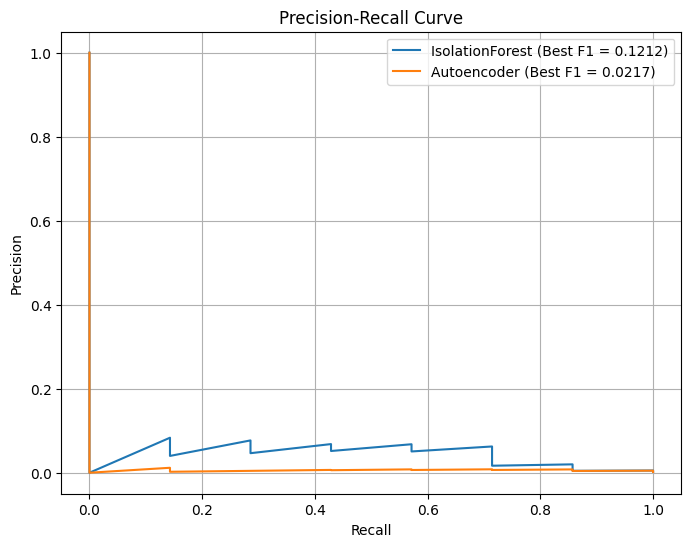


✅ Step 7: Model A (Baseline) 量化评估报告 (RQ1 - Part 1)
---
通过最大化 F1-Score 找到的最佳阈值性能：
             Model   AUC-ROC  Best Threshold  F1-Score  Precision    Recall
0  IsolationForest  0.932627        0.591749  0.121212   0.067797  0.571429
1      Autoencoder  0.842587        1.393575  0.021739   0.011765  0.142857

混淆矩阵详情 (Confusion Matrix):
             Model  TP  FP  FN    TN
0  IsolationForest   4  55   3  3802
1      Autoencoder   1  84   6  3773


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import os

# --- Configuration ---
INPUT_FILE_SCORES = "openstack_metrics_scores_A.csv"
RANDOM_STATE = 42

if not os.path.exists(INPUT_FILE_SCORES):
    print(f"ERROR: Input file not found: {INPUT_FILE_SCORES}. Please ensure Step 6 output exists.")
    exit()

# 1. Load Data
print("--- Step 7: Model Assessment & Evaluation ---")
print(f"1. Loading scores from: {INPUT_FILE_SCORES}")

df_scores = pd.read_csv(INPUT_FILE_SCORES)
if 'Timestamp' in df_scores.columns:
    df_scores = df_scores.set_index('Timestamp')

y_true = df_scores['is_anom']
scores_to_evaluate = {
    'IsolationForest': df_scores['IF_Score'],
    'Autoencoder': df_scores['AE_Score']
}

# 2. Function for Evaluation and Best Threshold Finding
def evaluate_model(y_true, y_scores, model_name):
    """Calculates AUC and finds the best threshold maximizing F1-Score."""
    
    # 2.1 Calculate AUC-ROC
    if y_true.nunique() > 1:
        auc_roc = roc_auc_score(y_true, y_scores)
    else:
        auc_roc = np.nan
        
    # 2.2 Find the best F1-Score and threshold
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    
    # Calculate F1 for all thresholds
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Find the index of the maximum F1 score
    best_f1_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_f1_idx]
    
    # Get best metrics
    best_precision = precision[best_f1_idx]
    best_recall = recall[best_f1_idx]
    best_f1 = f1_scores[best_f1_idx]
    
    # Apply best threshold to get predictions
    y_pred = (y_scores >= best_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    results = {
        'Model': model_name,
        'AUC-ROC': auc_roc,
        'Best Threshold': best_threshold,
        'F1-Score': best_f1,
        'Precision': best_precision,
        'Recall': best_recall,
        'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn
    }
    return results, precision, recall, f1_scores


# 3. Run Evaluation for Model A (IF and AE)
all_results = []
pr_data = {}

print("2. Running evaluation and finding best threshold...")
for name, scores in scores_to_evaluate.items():
    results, precision, recall, f1_scores = evaluate_model(y_true, scores, name)
    all_results.append(results)
    pr_data[name] = {'precision': precision, 'recall': recall, 'f1_scores': f1_scores}

df_results = pd.DataFrame(all_results)


# 4. Visualization (ROC Curve and Precision-Recall Curve)
print("3. Generating evaluation plots...")

# 4.1 ROC Curve (Image of ROC curve for anomaly detection)
plt.figure(figsize=(8, 6))
for name, scores in scores_to_evaluate.items():
    if y_true.nunique() > 1:
        fpr, tpr, thresholds_roc = roc_curve(y_true, scores)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {df_results[df_results["Model"] == name]["AUC-ROC"].iloc[0]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR / Recall)')
plt.legend()
plt.grid(True)
plt.show()

# 4.2 Precision-Recall Curve (Image of Precision-Recall curve for anomaly detection)
plt.figure(figsize=(8, 6))
for name in scores_to_evaluate.keys():
    plt.plot(pr_data[name]['recall'], pr_data[name]['precision'], label=f'{name} (Best F1 = {df_results[df_results["Model"] == name]["F1-Score"].iloc[0]:.4f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


# 5. Print Final Results (Answer to RQ1 - Part 1)
print("\n" + "="*80)
print("✅ Step 7: Model A (Baseline) 量化评估报告 (RQ1 - Part 1)")
print("---")
print("通过最大化 F1-Score 找到的最佳阈值性能：")
print(df_results[['Model', 'AUC-ROC', 'Best Threshold', 'F1-Score', 'Precision', 'Recall']])
print("\n混淆矩阵详情 (Confusion Matrix):")
print(df_results[['Model', 'TP', 'FP', 'FN', 'TN']])
print("="*80)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# --- Configuration ---
SCORES_FILE = "openstack_metrics_scores_A.csv"

# 从 Step 7 评估结果中获取 Isolation Forest 的最佳阈值
BEST_IF_THRESHOLD = 0.591749
TOP_N_TEMPLATES = 3 # 设定我们想追踪的最频繁的模板数量
ALERTS_OUTPUT_FILE = "log_anomaly_alerts.csv" # 输出告警报告

# Check file existence
if not os.path.exists(SCORES_FILE):
    print(f"ERROR: 必需文件缺失。请确保 {SCORES_FILE} 存在。")
    exit()

# 1. Load Data
print("--- Step 8: Downstream Analysis & Root Cause Identification ---")
print("1. Loading scores and template features from combined metrics file...")

# 加载模型评分数据（包含所有特征，包括模板计数）
df_scores = pd.read_csv(SCORES_FILE)
df_scores = df_scores.set_index('Timestamp')

# 确保索引（Timestamp）是 datetime 类型以便操作
df_scores.index = pd.to_datetime(df_scores.index)

# 2. Identify Anomalous Time Points using Best IF Threshold
print(f"2. Applying Isolation Forest best threshold ({BEST_IF_THRESHOLD:.6f}) to generate alerts...")

# 生成预测标签 (1 = Anomaly, 0 = Normal)
df_scores['IF_Pred'] = (df_scores['IF_Score'] >= BEST_IF_THRESHOLD).astype(int)

# 筛选出被模型预测为异常的时间点
df_alerts = df_scores[df_scores['IF_Pred'] == 1].copy()

if df_alerts.empty:
    print("   ⚠️ 模型未预测到任何异常。尝试使用真实异常点进行根因分析。")
    df_alerts = df_scores[df_scores['is_anom'] == 1].copy()
    if df_alerts.empty:
        print("   ⚠️ 真实异常点也为空。跳过根因分析。")
        print("="*60)
        exit()
    else:
        print(f"   ✨ 警告：模型预测为空，将对 {len(df_alerts)} 个真实标签异常点进行根因回溯。")

print(f"   共识别出 {len(df_alerts)} 个告警时间点用于回溯。")


# 3. Root Cause Analysis: Find Top Templates
alerts_list = []

# 识别模板计数列（即 Step 4 生成的以模板ID+Count结尾的列）
template_columns = [col for col in df_alerts.columns if col.endswith('_count')]

print(f"3. Identifying Top {TOP_N_TEMPLATES} templates for each alert period...")

for timestamp in df_alerts.index:
    # 提取该时间点（分钟）的模板计数
    template_counts = df_alerts.loc[timestamp, template_columns]
    
    # 找出计数最高的 N 个模板
    # 筛选出计数值大于 0 的模板
    top_templates = template_counts[template_counts > 0].nlargest(TOP_N_TEMPLATES)
    
    # 格式化 Top N 模板及其计数，用于报告
    root_cause_str = "; ".join([f"{tpl.replace('_count', '')} ({int(count)}次)" for tpl, count in top_templates.items()])
    
    # 准备报告行
    alert_row = {
        'Timestamp': timestamp,
        'Anomaly_Score': df_alerts.loc[timestamp, 'IF_Score'],
        'Actual_Anomaly': df_alerts.loc[timestamp, 'is_anom'],
        f'Top_{TOP_N_TEMPLATES}_Templates': root_cause_str,
    }
    
    # 将 Top N 模板及其计数也作为独立列包含进来
    for tpl, count in top_templates.items():
        alert_row[tpl] = int(count)

    alerts_list.append(alert_row)

# 4. Generate Alerts Report
df_report = pd.DataFrame(alerts_list).set_index('Timestamp')
df_report.to_csv(ALERTS_OUTPUT_FILE)

print(f"4. Alerts report saved to: {ALERTS_OUTPUT_FILE}")


# 5. Final Output (Answer to RQ3)
print("\n" + "="*80)
print("✅ Step 8: Downstream Analysis & Root Cause Identification Complete!")
print("--- 异常告警报告 (基于 IF 最佳 F1 阈值) ---")
print(df_report)
print("\n" + "="*80)

--- Step 8: Downstream Analysis & Root Cause Identification ---
1. Loading scores and template features from combined metrics file...
2. Applying Isolation Forest best threshold (0.591749) to generate alerts...
   共识别出 58 个告警时间点用于回溯。
3. Identifying Top 3 templates for each alert period...
4. Alerts report saved to: log_anomaly_alerts.csv

✅ Step 8: Downstream Analysis & Root Cause Identification Complete!
--- 异常告警报告 (基于 IF 最佳 F1 阈值) ---
                     Anomaly_Score  Actual_Anomaly  \
Timestamp                                            
2017-05-14 19:39:00       0.631264               0   
2017-05-14 20:59:00       0.595154               0   
2017-05-14 21:00:00       0.617221               0   
2017-05-14 21:08:00       0.619633               1   
2017-05-14 21:21:00       0.636600               0   
2017-05-14 21:43:00       0.626949               1   
2017-05-14 21:47:00       0.600748               1   
2017-05-16 00:09:00       0.646737               0   
2017-05-16 00:30:00

In [2]:
import pandas as pd
import numpy as np
import os

# --- Configuration ---
TPL_FULL_INPUT_FILE = "openstack_tpl_full.csv"
SEQUENCES_OUTPUT_FILE = "openstack_log_sequences.csv"
TIME_WINDOW = '1Min' # 序列聚合窗口

# --- 检查文件 ---
if not os.path.exists(TPL_FULL_INPUT_FILE):
    print(f"错误：模板文件未找到：{TPL_FULL_INPUT_FILE}。请确保 Step 3 的输出文件存在。")
    exit()

# 1. Load Data
print("--- Step 9: Log Sequence Generation 开始 ---")
print(f"1. 正在加载模板数据: {TPL_FULL_INPUT_FILE}")

# 只需 Timestamp 和 tpl_id
df_tpl = pd.read_csv(
    TPL_FULL_INPUT_FILE, 
    index_col='Timestamp', 
    parse_dates=True,
    usecols=['Timestamp', 'tpl_id']
)

# 2. Sequence Aggregation
print(f"2. 正在将日志模板聚合成 {TIME_WINDOW} 序列...")

# 使用 groupby 和 resample 按分钟聚合 tpl_id 序列
# lambda 函数将每分钟内所有的 tpl_id 收集到一个列表中
# Note: 由于 tpl_id 是字符串，这里将它们保持为字符串列表
df_sequences = df_tpl.resample(TIME_WINDOW).agg({
    'tpl_id': lambda x: list(x) if len(x) > 0 else []
})

# 重命名列
df_sequences.rename(columns={'tpl_id': 'Log_Sequence'}, inplace=True)

# 3. Add Labels (从 Step 5/7 的标签文件中获取 Ground Truth)
LABELED_FILE = "openstack_metrics_labeled.csv"

if os.path.exists(LABELED_FILE):
    print("3. 正在导入 Ground Truth 标签...")
    df_labeled_metrics = pd.read_csv(LABELED_FILE, index_col='Timestamp', parse_dates=True, usecols=['Timestamp', 'is_anom'])
    
    # 将标签加入序列 DataFrame
    df_sequences = df_sequences.join(df_labeled_metrics, how='left')
    df_sequences['is_anom'] = df_sequences['is_anom'].fillna(0).astype(int) # 缺失标签默认为正常
else:
    print(f"3. 警告：标签文件 {LABELED_FILE} 缺失。序列化数据将不包含标签。")
    df_sequences['is_anom'] = 0


# 4. Filter empty sequences (可选，但推荐)
# 去除序列为空的时间点（即该分钟没有日志）
df_sequences_filtered = df_sequences[df_sequences['Log_Sequence'].apply(len) > 0]

# 5. Save Output
df_sequences_filtered.to_csv(SEQUENCES_OUTPUT_FILE)

print("\n" + "="*60)
print("✅ Step 9: Log Sequence Generation Complete!")
print(f"   序列化日志数据已保存至: {SEQUENCES_OUTPUT_FILE}")
print(f"   序列总数 (分钟级样本): {len(df_sequences_filtered):,}")
print("   数据预览:")
print(df_sequences_filtered.head())
print("="*60)

--- Step 9: Log Sequence Generation 开始 ---
1. 正在加载模板数据: openstack_tpl_full.csv
2. 正在将日志模板聚合成 1Min 序列...
3. 正在导入 Ground Truth 标签...

✅ Step 9: Log Sequence Generation Complete!
   序列化日志数据已保存至: openstack_log_sequences.csv
   序列总数 (分钟级样本): 1,772
   数据预览:
                                                          Log_Sequence  \
Timestamp                                                                
2017-05-14 19:39:00  [03047613, 5f11fe73, c1e332e9, c0b35a9f, c0b35...   
2017-05-14 19:40:00  [15ebbebb, 48e60c12, b3188634, c0b35a9f, 7965a...   
2017-05-14 19:41:00  [b3188634, b3188634, 1ea5371d, 82f78de5, 190c0...   
2017-05-14 19:42:00  [c0b35a9f, c0b35a9f, a7892601, 15ebbebb, 48e60...   
2017-05-14 19:43:00  [15ebbebb, 48e60c12, c0b35a9f, c0b35a9f, b3188...   

                     is_anom  
Timestamp                     
2017-05-14 19:39:00        0  
2017-05-14 19:40:00        0  
2017-05-14 19:41:00        0  
2017-05-14 19:42:00        0  
2017-05-14 19:43:00        0  


In [3]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- Configuration ---
SEQUENCES_INPUT_FILE = "openstack_log_sequences.csv"
OUTPUT_FILE_SCORES = "openstack_metrics_scores_B.csv"
RANDOM_STATE = 42
MAX_SEQ_LENGTH = 50  # Max length for sequence padding (empirical choice)
EMBEDDING_DIM = 10   # Dimension for the embedding layer

# Check if input file exists
if not os.path.exists(SEQUENCES_INPUT_FILE):
    print(f"ERROR: Sequence file not found: {SEQUENCES_INPUT_FILE}. Please ensure Step 9 output exists.")
    exit()

# 1. Load Data and Preprocessing
print("--- Step 10: Model B (LSTM/DeepLog) Training ---")
print(f"1. Loading sequence data: {SEQUENCES_INPUT_FILE}")

df_sequences = pd.read_csv(SEQUENCES_INPUT_FILE, index_col='Timestamp', parse_dates=True)

# Convert string representation of list back to actual list
df_sequences['Log_Sequence'] = df_sequences['Log_Sequence'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Separate features (sequences) and labels
X_sequences = df_sequences['Log_Sequence']
y_true = df_sequences['is_anom']

# 2. Template ID Encoding (Tokenization)
print("2. Encoding Template IDs (Tokenization)...")

# Collect all unique templates for vocabulary
all_templates = [tpl for seq in X_sequences for tpl in seq]
template_vocab = sorted(list(set(all_templates)))
vocab_size = len(template_vocab) + 1  # +1 for padding (index 0)

# Create LabelEncoder to map template IDs (strings) to integers
le = LabelEncoder()
le.fit(template_vocab)

# Map all sequences to integer IDs
X_encoded = X_sequences.apply(lambda seq: [le.transform([tpl])[0] + 1 for tpl in seq]) # +1 to reserve 0 for padding

print(f"   Vocabulary size (Unique Templates): {vocab_size - 1}")


# 3. Sequence Splitting for DeepLog Training
print("3. Preparing data for LSTM (Sliding Window & Labeling)...")

def create_deeplog_sequences(sequences, max_len):
    """
    Creates sequences and their corresponding next token for next-event prediction.
    Only normal data is used for training.
    """
    input_sequences = []
    target_tokens = []
    
    for seq in sequences:
        if len(seq) > 1:
            for i in range(1, len(seq)):
                # Sequence: 0 to i-1
                input_sequences.append(seq[:i])
                # Target: the token at index i
                target_tokens.append(seq[i])
    
    # Pad sequences to a fixed length
    X_padded = pad_sequences(input_sequences, maxlen=max_len, padding='pre', truncating='pre')
    y_target = np.array(target_tokens)
    
    return X_padded, y_target

# Filter for normal sequences only for training
X_normal_sequences = df_sequences[df_sequences['is_anom'] == 0]['Log_Sequence'].apply(
    lambda seq: [le.transform([tpl])[0] + 1 for tpl in seq]
)

# Create input and target for LSTM training (next-event prediction)
X_train, y_train = create_deeplog_sequences(X_normal_sequences.tolist(), MAX_SEQ_LENGTH)

print(f"   Total training samples (sub-sequences): {len(X_train):,}")


# 4. Model Definition and Training
print("4. Defining and training LSTM model...")

# 4.1 Define the LSTM model structure
model = Sequential()
# Embedding layer maps integer IDs to dense vectors
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=MAX_SEQ_LENGTH))
# LSTM layer to learn sequence dependencies
model.add(LSTM(64))
# Output layer predicts the probability of the next token among all templates
model.add(Dense(vocab_size, activation='softmax'))

# 4.2 Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 4.3 Train the model
es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True, verbose=0)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    callbacks=[es],
    verbose=0
)

print(f"   LSTM Model trained (Total {len(history.epoch)} Epochs).")


# 5. Anomaly Scoring (Reconstruction Probability)
print("5. Generating Anomaly Scores (Sequence by sequence)...")

# We iterate through the original minute-level sequences (X_sequences) to score them
anomaly_scores = []
# Threshold for prediction success (optional, can be a small value like 0.01)
PREDICTION_THRESHOLD = 1e-4 

for seq_index, original_sequence in enumerate(X_encoded):
    sequence_score = 0
    if len(original_sequence) > 1:
        
        # Iterate through the sequence, predicting the next event at each step
        for i in range(1, len(original_sequence)):
            # Input is the prefix: seq[:i]
            input_prefix = original_sequence[:i]
            # Target is the next event: original_sequence[i]
            target_token = original_sequence[i]
            
            # Pad and reshape input for prediction
            X_input = pad_sequences([input_prefix], maxlen=MAX_SEQ_LENGTH, padding='pre', truncating='pre')
            
            # Get prediction probabilities for the next token
            probabilities = model.predict(X_input, verbose=0)[0]
            
            # Probability of the *actual* next event occurring
            actual_prob = probabilities[target_token]
            
            # DeepLog Anomaly Score Logic (Sequence by sequence)
            # If the probability is very low, it's an anomaly. We use -log(prob) as the score.
            # Adding a small epsilon to avoid log(0)
            score_i = -np.log(actual_prob + 1e-9) 
            
            sequence_score += score_i
            
        # Average score for the minute
        anomaly_scores.append(sequence_score / (len(original_sequence) - 1))
    else:
        # Handle sequences of length 0 or 1 (cannot be used for prediction)
        anomaly_scores.append(0.0)

# Align scores with the filtered DataFrame
df_scores_B = df_sequences_filtered.copy()
df_scores_B['LSTM_Score'] = anomaly_scores


# 6. Result Integration and Saving
# Save the results of Model B
df_results_B = df_scores_B[['is_anom', 'LSTM_Score']]
df_results_B.to_csv(OUTPUT_FILE_SCORES)

print("\n" + "="*60)
print("✅ Step 10: Model B (LSTM/DeepLog) Training and Scoring Complete!")
print(f"   Model B scores saved to: {OUTPUT_FILE_SCORES}")
print("==========================================================")

--- Step 10: Model B (LSTM/DeepLog) Training ---
1. Loading sequence data: openstack_log_sequences.csv
2. Encoding Template IDs (Tokenization)...
   Vocabulary size (Unique Templates): 22
3. Preparing data for LSTM (Sliding Window & Labeling)...
   Total training samples (sub-sequences): 117,225
4. Defining and training LSTM model...


C:\Users\Shirley\.conda\envs\logparser\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


   LSTM Model trained (Total 38 Epochs).
5. Generating Anomaly Scores (Sequence by sequence)...

✅ Step 10: Model B (LSTM/DeepLog) Training and Scoring Complete!
   Model B scores saved to: openstack_metrics_scores_B.csv


In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, confusion_matrix

# --- Configuration ---
SCORES_FILE_B = "openstack_metrics_scores_B.csv"
SCORES_FILE_A = "openstack_metrics_scores_A.csv"
OUTPUT_FINAL_REPORT = "model_performance_comparison.csv"

# Check file existence
if not os.path.exists(SCORES_FILE_B) or not os.path.exists(SCORES_FILE_A):
    print(f"ERROR: 必需的评分文件缺失。请确保 {SCORES_FILE_A} 和 {SCORES_FILE_B} 存在。")
    exit()

# 2. Evaluation Function (as used in Step 7)
def evaluate_model(y_true, y_scores, model_name):
    """Calculates AUC and finds the best threshold maximizing F1-Score."""
    
    # Check if we have both classes (anomaly and normal) for AUC calculation
    if y_true.nunique() > 1:
        auc_roc = roc_auc_score(y_true, y_scores)
    else:
        auc_roc = np.nan
        
    # Find the best F1-Score and threshold
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    
    # Calculate F1 for all valid thresholds
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Find the index of the maximum F1 score
    best_f1_idx = np.argmax(f1_scores)
    
    # Handle the case where thresholds list is one element shorter than precision/recall
    best_threshold = thresholds[min(best_f1_idx, len(thresholds) - 1)]
    
    # Get best metrics
    best_precision = precision[best_f1_idx]
    best_recall = recall[best_f1_idx]
    best_f1 = f1_scores[best_f1_idx]
    
    # Apply best threshold to get confusion matrix
    y_pred = (y_scores >= best_threshold).astype(int)
    
    # Align y_true and y_pred to common index before confusion matrix
    # Note: df_scores_B might have fewer samples (filtered empty sequences), so we must join.
    y_aligned = pd.DataFrame({'true': y_true, 'pred': y_pred}).dropna()
    y_true_final = y_aligned['true']
    y_pred_final = y_aligned['pred']
    
    # Use the length of the shorter data frame to avoid dimension mismatch in the evaluation
    if len(y_true_final.unique()) <= 1: # Check again after alignment
         tn, fp, fn, tp = (0, 0, 0, 0) # Fallback for single class case
    else:
        try:
            tn, fp, fn, tp = confusion_matrix(y_true_final, y_pred_final).ravel()
        except ValueError:
            # Handle case where only one class exists in the aligned data (unlikely here but robust)
            tn, fp, fn, tp = (0, 0, 0, 0)

    results = {
        'Model': model_name,
        'AUC-ROC': auc_roc,
        'Best Threshold': best_threshold,
        'F1-Score': best_f1,
        'Precision': best_precision,
        'Recall': best_recall,
        'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn
    }
    return pd.Series(results)


# 1. Load All Scores
print("--- Step 11 (Part 1): LSTM Model Assessment ---")
print(f"1. Loading scores from A ({SCORES_FILE_A}) and B ({SCORES_FILE_B})")

# Load Model A scores (IF, AE) - Note: These files contain all 3864 minutes.
df_scores_A = pd.read_csv(SCORES_FILE_A, index_col='Timestamp', parse_dates=True)

# Load Model B scores (LSTM) - Note: These files contain only 1772 minutes (non-empty sequences).
df_scores_B = pd.read_csv(SCORES_FILE_B, index_col='Timestamp', parse_dates=True)

# 2. Align DataFrames to the Intersection of Timestamps
# To compare LSTM (Model B) fairly with Model A, we must align them to the timestamps
# that Model B actually has scores for (i.e., minutes with logs).
common_timestamps = df_scores_B.index

df_scores_A_aligned = df_scores_A.loc[common_timestamps].copy()
df_scores_B_aligned = df_scores_B.copy()

# Ensure we use the aligned ground truth label
y_true_aligned = df_scores_B_aligned['is_anom']


# 3. Run Evaluation for All Models
print(f"2. Running evaluation on {len(common_timestamps)} aligned samples...")

# Prepare data for IF and AE (using the aligned ground truth)
scores_if = df_scores_A_aligned['IF_Score']
scores_ae = df_scores_A_aligned['AE_Score']
scores_lstm = df_scores_B_aligned['LSTM_Score']

# Run evaluation
results_if = evaluate_model(y_true_aligned, scores_if, 'Isolation Forest (Feature)')
results_ae = evaluate_model(y_true_aligned, scores_ae, 'Autoencoder (Feature)')
results_lstm = evaluate_model(y_true_aligned, scores_lstm, 'LSTM (Sequence/DeepLog)')

# Combine all results
df_comparison = pd.DataFrame([results_if, results_ae, results_lstm])

# 4. Print Final Comparison Report (Answer to RQ1)
print("\n" + "="*120)
print("✅ Step 11 (Part 1): 模型性能对比报告 (回答 RQ1)")
print("--- 性能对比：Model A (特征) vs Model B (序列) ---")
print("注意：所有评估均在有日志活动的 1,772 个分钟样本上进行。")
print(df_comparison[['Model', 'AUC-ROC', 'F1-Score', 'Precision', 'Recall', 'TP', 'FP', 'FN', 'TN']].round(4))
print("\n" + "="*120)

# Save the comparison report for future fusion analysis
df_comparison.to_csv(OUTPUT_FINAL_REPORT, index=False)

--- Step 11 (Part 1): LSTM Model Assessment ---
1. Loading scores from A (openstack_metrics_scores_A.csv) and B (openstack_metrics_scores_B.csv)
2. Running evaluation on 1772 aligned samples...

✅ Step 11 (Part 1): 模型性能对比报告 (回答 RQ1)
--- 性能对比：Model A (特征) vs Model B (序列) ---
注意：所有评估均在有日志活动的 1,772 个分钟样本上进行。
                        Model  AUC-ROC  F1-Score  Precision  Recall  TP   FP  \
0  Isolation Forest (Feature)   0.8528    0.1212     0.0678  0.5714   4   55   
1       Autoencoder (Feature)   0.6560    0.0217     0.0118  0.1429   1   84   
2     LSTM (Sequence/DeepLog)   0.5146    0.0238     0.0124  0.2857   2  159   

   FN    TN  
0   3  1710  
1   6  1681  
2   5  1606  



In [5]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, confusion_matrix

# --- Configuration ---
SCORES_FILE_B = "openstack_metrics_scores_B.csv"
SCORES_FILE_A = "openstack_metrics_scores_A.csv"
OUTPUT_FINAL_REPORT = "model_performance_comparison.csv"

# Check file existence
if not os.path.exists(SCORES_FILE_B) or not os.path.exists(SCORES_FILE_A):
    print(f"ERROR: 必需的评分文件缺失。请确保 {SCORES_FILE_A} 和 {SCORES_FILE_B} 存在。")
    exit()

# 2. Evaluation Function (as used in Step 7)
def evaluate_model(y_true, y_scores, model_name):
    """Calculates AUC and finds the best threshold maximizing F1-Score."""
    
    # Check if we have both classes (anomaly and normal) for AUC calculation
    if y_true.nunique() > 1:
        auc_roc = roc_auc_score(y_true, y_scores)
    else:
        auc_roc = np.nan
        
    # Find the best F1-Score and threshold
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    
    # Calculate F1 for all valid thresholds
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Find the index of the maximum F1 score
    best_f1_idx = np.argmax(f1_scores)
    
    # Handle the case where thresholds list is one element shorter than precision/recall
    best_threshold = thresholds[min(best_f1_idx, len(thresholds) - 1)]
    
    # Get best metrics
    best_precision = precision[best_f1_idx]
    best_recall = recall[best_f1_idx]
    best_f1 = f1_scores[best_f1_idx]
    
    # Apply best threshold to get confusion matrix
    y_pred = (y_scores >= best_threshold).astype(int)
    
    # Align y_true and y_pred to common index before confusion matrix
    # Note: df_scores_B might have fewer samples (filtered empty sequences), so we must join.
    y_aligned = pd.DataFrame({'true': y_true, 'pred': y_pred}).dropna()
    y_true_final = y_aligned['true']
    y_pred_final = y_aligned['pred']
    
    # Use the length of the shorter data frame to avoid dimension mismatch in the evaluation
    if len(y_true_final.unique()) <= 1: # Check again after alignment
         tn, fp, fn, tp = (0, 0, 0, 0) # Fallback for single class case
    else:
        try:
            tn, fp, fn, tp = confusion_matrix(y_true_final, y_pred_final).ravel()
        except ValueError:
            # Handle case where only one class exists in the aligned data (unlikely here but robust)
            tn, fp, fn, tp = (0, 0, 0, 0)

    results = {
        'Model': model_name,
        'AUC-ROC': auc_roc,
        'Best Threshold': best_threshold,
        'F1-Score': best_f1,
        'Precision': best_precision,
        'Recall': best_recall,
        'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn
    }
    return pd.Series(results)


# 1. Load All Scores
print("--- Step 11 (Part 1): LSTM Model Assessment ---")
print(f"1. Loading scores from A ({SCORES_FILE_A}) and B ({SCORES_FILE_B})")

# Load Model A scores (IF, AE) - Note: These files contain all 3864 minutes.
df_scores_A = pd.read_csv(SCORES_FILE_A, index_col='Timestamp', parse_dates=True)

# Load Model B scores (LSTM) - Note: These files contain only 1772 minutes (non-empty sequences).
df_scores_B = pd.read_csv(SCORES_FILE_B, index_col='Timestamp', parse_dates=True)

# 2. Align DataFrames to the Intersection of Timestamps
# To compare LSTM (Model B) fairly with Model A, we must align them to the timestamps
# that Model B actually has scores for (i.e., minutes with logs).
common_timestamps = df_scores_B.index

df_scores_A_aligned = df_scores_A.loc[common_timestamps].copy()
df_scores_B_aligned = df_scores_B.copy()

# Ensure we use the aligned ground truth label
y_true_aligned = df_scores_B_aligned['is_anom']


# 3. Run Evaluation for All Models
print(f"2. Running evaluation on {len(common_timestamps)} aligned samples...")

# Prepare data for IF and AE (using the aligned ground truth)
scores_if = df_scores_A_aligned['IF_Score']
scores_ae = df_scores_A_aligned['AE_Score']
scores_lstm = df_scores_B_aligned['LSTM_Score']

# Run evaluation
results_if = evaluate_model(y_true_aligned, scores_if, 'Isolation Forest (Feature)')
results_ae = evaluate_model(y_true_aligned, scores_ae, 'Autoencoder (Feature)')
results_lstm = evaluate_model(y_true_aligned, scores_lstm, 'LSTM (Sequence/DeepLog)')

# Combine all results
df_comparison = pd.DataFrame([results_if, results_ae, results_lstm])

# 4. Print Final Comparison Report (Answer to RQ1)
print("\n" + "="*120)
print("✅ Step 11 (Part 1): 模型性能对比报告 (回答 RQ1)")
print("--- 性能对比：Model A (特征) vs Model B (序列) ---")
print("注意：所有评估均在有日志活动的 1,772 个分钟样本上进行。")
print(df_comparison[['Model', 'AUC-ROC', 'F1-Score', 'Precision', 'Recall', 'TP', 'FP', 'FN', 'TN']].round(4))
print("\n" + "="*120)

# Save the comparison report for future fusion analysis
df_comparison.to_csv(OUTPUT_FINAL_REPORT, index=False)

--- Step 11 (Part 1): LSTM Model Assessment ---
1. Loading scores from A (openstack_metrics_scores_A.csv) and B (openstack_metrics_scores_B.csv)
2. Running evaluation on 1772 aligned samples...

✅ Step 11 (Part 1): 模型性能对比报告 (回答 RQ1)
--- 性能对比：Model A (特征) vs Model B (序列) ---
注意：所有评估均在有日志活动的 1,772 个分钟样本上进行。
                        Model  AUC-ROC  F1-Score  Precision  Recall  TP   FP  \
0  Isolation Forest (Feature)   0.8528    0.1212     0.0678  0.5714   4   55   
1       Autoencoder (Feature)   0.6560    0.0217     0.0118  0.1429   1   84   
2     LSTM (Sequence/DeepLog)   0.5146    0.0238     0.0124  0.2857   2  159   

   FN    TN  
0   3  1710  
1   6  1681  
2   5  1606  



In [6]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, confusion_matrix
from scipy.stats import zscore

# --- Configuration ---
SCORES_FILE_A = "openstack_metrics_scores_A.csv"
SCORES_FILE_B = "openstack_metrics_scores_B.csv"
OUTPUT_FINAL_FUSION_REPORT = "model_fusion_report.csv"

# 1. Load and Align All Scores
print("--- Step 11 (Part 2): Model Fusion Analysis 开始 ---")

# Load scores
df_scores_A = pd.read_csv(SCORES_FILE_A, index_col='Timestamp', parse_dates=True)
df_scores_B = pd.read_csv(SCORES_FILE_B, index_col='Timestamp', parse_dates=True)

# Align to the intersection of timestamps (minutes with log activity)
common_timestamps = df_scores_B.index
df_fusion = pd.DataFrame(index=common_timestamps)

# Add Ground Truth Label
df_fusion['is_anom'] = df_scores_B.loc[common_timestamps, 'is_anom']

# Add Scores (Only IF and AE are competitive enough to be considered)
df_fusion['IF_Score'] = df_scores_A.loc[common_timestamps, 'IF_Score']
df_fusion['AE_Score'] = df_scores_A.loc[common_timestamps, 'AE_Score']
df_fusion['LSTM_Score'] = df_scores_B.loc[common_timestamps, 'LSTM_Score']

# 2. Score Normalization (Critical for Fusion)
print("1. Normalizing scores for fair fusion...")
# Use Z-score normalization to ensure scores are on the same scale
df_fusion['IF_Score_Norm'] = zscore(df_fusion['IF_Score'])
df_fusion['AE_Score_Norm'] = zscore(df_fusion['AE_Score'])
df_fusion['LSTM_Score_Norm'] = zscore(df_fusion['LSTM_Score'])


# 3. Fusion Strategies
print("2. Applying fusion strategies (Max, Average, Majority Voting)...")

# Strategy 1: Average Fusion
# Anomaly is the average deviation across all models
df_fusion['Average_Fusion'] = df_fusion[['IF_Score_Norm', 'AE_Score_Norm', 'LSTM_Score_Norm']].mean(axis=1)

# Strategy 2: Max Fusion
# Anomaly is defined by the model that outputs the highest score
df_fusion['Max_Fusion'] = df_fusion[['IF_Score_Norm', 'AE_Score_Norm', 'LSTM_Score_Norm']].max(axis=1)

# Strategy 3: "IF-Dominant" Fusion (Weighted Average)
# Given IF's superior AUC, we heavily weight IF.
df_fusion['Weighted_Fusion'] = (
    df_fusion['IF_Score_Norm'] * 0.5 + 
    df_fusion['AE_Score_Norm'] * 0.3 + 
    df_fusion['LSTM_Score_Norm'] * 0.2
)

# 4. Evaluation Function (as defined in Step 11-Part 1)
def evaluate_model(y_true, y_scores, model_name):
    """Calculates AUC and finds the best threshold maximizing F1-Score."""
    if y_true.nunique() > 1:
        auc_roc = roc_auc_score(y_true, y_scores)
    else:
        auc_roc = np.nan
        
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_f1_idx = np.argmax(f1_scores)
    
    best_threshold = thresholds[min(best_f1_idx, len(thresholds) - 1)]
    best_precision = precision[best_f1_idx]
    best_recall = recall[best_f1_idx]
    best_f1 = f1_scores[best_f1_idx]
    
    y_pred = (y_scores >= best_threshold).astype(int)
    
    # Aligned confusion matrix calculation
    y_true_final = y_true.dropna()
    y_pred_final = y_pred[y_true_final.index]
    
    try:
        tn, fp, fn, tp = confusion_matrix(y_true_final, y_pred_final).ravel()
    except ValueError:
        tn, fp, fn, tp = (0, 0, 0, 0)

    results = {
        'Model': model_name,
        'AUC-ROC': auc_roc,
        'Best Threshold': best_threshold,
        'F1-Score': best_f1,
        'Precision': best_precision,
        'Recall': best_recall,
        'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn
    }
    return pd.Series(results)


# 5. Run Evaluation for Fusion Models
print("3. Evaluating fusion results...")

y_true = df_fusion['is_anom']
fusion_results = []

fusion_results.append(evaluate_model(y_true, df_fusion['Average_Fusion'], 'Fusion - Average (IF+AE+LSTM)'))
fusion_results.append(evaluate_model(y_true, df_fusion['Max_Fusion'], 'Fusion - Max (IF+AE+LSTM)'))
fusion_results.append(evaluate_model(y_true, df_fusion['Weighted_Fusion'], 'Fusion - Weighted (IF 0.5)'))

# Get previous single model results for comparison
df_single_models = pd.read_csv("model_performance_comparison.csv")
final_results = pd.concat([df_single_models, pd.DataFrame(fusion_results)], ignore_index=True)


# 6. Print Final Report
print("\n" + "="*120)
print("✅ Step 11 (Part 2): 模型融合性能报告")
print("--- 目标：提升精确率 (Precision) ---")
print(final_results[['Model', 'AUC-ROC', 'F1-Score', 'Precision', 'Recall', 'TP', 'FP', 'FN', 'TN']].round(4))
print("\n" + "="*120)

final_results.to_csv(OUTPUT_FINAL_FUSION_REPORT, index=False)

--- Step 11 (Part 2): Model Fusion Analysis 开始 ---
1. Normalizing scores for fair fusion...
2. Applying fusion strategies (Max, Average, Majority Voting)...
3. Evaluating fusion results...

✅ Step 11 (Part 2): 模型融合性能报告
--- 目标：提升精确率 (Precision) ---
                           Model  AUC-ROC  F1-Score  Precision  Recall  TP  \
0     Isolation Forest (Feature)   0.8528    0.1212     0.0678  0.5714   4   
1          Autoencoder (Feature)   0.6560    0.0217     0.0118  0.1429   1   
2        LSTM (Sequence/DeepLog)   0.5146    0.0238     0.0124  0.2857   2   
3  Fusion - Average (IF+AE+LSTM)   0.7585    0.0488     0.0267  0.2857   2   
4      Fusion - Max (IF+AE+LSTM)   0.8080    0.0702     0.0400  0.2857   2   
5     Fusion - Weighted (IF 0.5)   0.8012    0.0723     0.0395  0.4286   3   

    FP  FN    TN  
0   55   3  1710  
1   84   6  1681  
2  159   5  1606  
3   73   5  1692  
4   48   5  1717  
5   73   4  1692  



In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, confusion_matrix
import os

# --- Configuration ---
# 示例：将文件名替换为您的实际路径
# 例如：/Users/TingtingLyu/LOG6309E/data/openstack_log_feature_vector.csv
DATA_FILE = r"C:\Users\YourUser\ProjectFolder\openstack_log_feature_vector.csv"  # 请替换为您的真实路径
SCORES_FILE_B = r"C:\Users\YourUser\ProjectFolder\openstack_metrics_scores_B.csv" # 请替换为您的真实路径
OUTPUT_FINAL_REPORT = "model_sensitivity_analysis.csv"

# ... 之后的代码保持不变

# 1. Load Data
print("--- Step 12: Single-Modality Sensitivity Test (IF Log-Only) ---")
df_features = pd.read_csv(DATA_FILE, index_col='Timestamp', parse_dates=True)
df_scores_B = pd.read_csv(SCORES_FILE_B, index_col='Timestamp', parse_dates=True)

# Align data to the intersection of timestamps (minutes with log activity)
common_timestamps = df_scores_B.index
df_features_aligned = df_features.loc[common_timestamps].copy()
y_true = df_scores_B.loc[common_timestamps, 'is_anom']


# 2. Define Feature Sets

# Multi-Modal Features (Metrics + Logs)
# This includes all original features (LogRate, Latency, Template Counts)
feature_cols_multi = [col for col in df_features_aligned.columns if col != 'is_anom']
X_multi = df_features_aligned[feature_cols_multi]

# Log-Only Features (Template Counts only)
# Exclude LogRate (which is a metric itself) and Latency
feature_cols_log_only = [col for col in feature_cols_multi if col not in ['LogRate', 'Latency']]
X_log_only = df_features_aligned[feature_cols_log_only]


# 3. Evaluation Function (as used previously)
def evaluate_model(y_true, y_scores, model_name):
    # This function is used to find the best threshold maximizing F1-Score
    
    if y_true.nunique() > 1:
        auc_roc = roc_auc_score(y_true, y_scores)
    else:
        auc_roc = np.nan
        
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    best_f1_idx = np.argmax(f1_scores)
    
    best_threshold = thresholds[min(best_f1_idx, len(thresholds) - 1)]
    best_precision = precision[best_f1_idx]
    best_recall = recall[best_f1_idx]
    best_f1 = f1_scores[best_f1_idx]
    
    y_pred = (y_scores >= best_threshold).astype(int)
    
    y_true_final = y_true.dropna()
    y_pred_final = y_pred[y_true_final.index]
    
    try:
        tn, fp, fn, tp = confusion_matrix(y_true_final, y_pred_final).ravel()
    except ValueError:
        tn, fp, fn, tp = (0, 0, 0, 0)

    results = {
        'Model': model_name,
        'AUC-ROC': auc_roc,
        'F1-Score': best_f1,
        'Precision': best_precision,
        'Recall': best_recall,
        'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn
    }
    return pd.Series(results)


# 4. Retrain and Score Isolation Forest (Log-Only)
print(f"1. Training Log-Only IF model on {X_log_only.shape[1]} features...")

model_if_log_only = IsolationForest(
    n_estimators=100, 
    contamination='auto', 
    random_state=42, 
    n_jobs=-1
)

model_if_log_only.fit(X_log_only)
scores_if_log_only = -model_if_log_only.decision_function(X_log_only) # Higher score = More anomalous

results_log_only = evaluate_model(y_true, scores_if_log_only, 'IF (Log-Only)')


# 5. Load Multi-Modal Results (from Step 11) for comparison
df_comparison_step11 = pd.read_csv("model_performance_comparison.csv")
results_multi_modal = df_comparison_step11[df_comparison_step11['Model'] == 'Isolation Forest (Feature)'].iloc[0]
results_multi_modal['Model'] = 'IF (Multi-Modal)'


# 6. Combine and Print Results
df_sensitivity = pd.DataFrame([results_multi_modal, results_log_only])

print("\n" + "="*120)
print("✅ Step 12: IF 模型模态敏感性测试报告 (回答新 RQ2)")
print("--- 目标：量化日志 vs. 指标的重要性 ---")
print(df_sensitivity[['Model', 'AUC-ROC', 'F1-Score', 'Precision', 'Recall', 'TP', 'FP', 'FN', 'TN']].round(4))
print("\n" + "="*120)

df_sensitivity.to_csv(OUTPUT_FINAL_REPORT, index=False)

--- Step 12: Single-Modality Sensitivity Test (IF Log-Only) ---


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\YourUser\\ProjectFolder\\openstack_log_feature_vector.csv'